In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import ee # Google Earth Engine

In [2]:
# Force re-authentication
ee.Authenticate()

True

In [3]:
PROJECT_ID = "miningcandb"  
ee.Initialize(project=PROJECT_ID) 
print("✅ Earth Engine is now initialized with project:", PROJECT_ID)

✅ Earth Engine is now initialized with project: miningcandb


# Clean and import datasets

In [4]:
# Canada SHP files
canada_boundary = gpd.read_file("data/Sources/Canada_boundary/Canada_boundary.shp")
canada_provinces = gpd.read_file("data/Sources/Canada_provinces_boundary/lpr_000b21a_e.shp")

In [5]:
# MinCan datasets
min_can_df = pd.read_csv(
    r'data/cleaned_data/min_can_cleaned_df.csv')

In [6]:
# NRCan datasets
nrcan_mining_df = pd.read_excel(
    r'data/NRCan/Principal Mineral Areas, Producing Mines, and Oil and Gas Fields (900A)/nrcan_mining_df.xlsx')
nrcan_manufacturing_df = pd.read_excel(
    r'data/NRCan/Principal Mineral Areas, Producing Mines, and Oil and Gas Fields (900A)/nrcan_manufacturing_df.xlsx')
nrcan_critical_df = pd.read_excel(
    r'data/NRCan/Critical minerals advanced projects, mines and processing facilities in Canada/Critical minerals advanced projects, mines and processing facilities.xlsx'
)

In [7]:
# GHG from large facilities datasets
ghg_facility_metal_mining_df = pd.read_csv(
    r'data/cleaned_data/ghg_facility_metal_mining_df.csv')
ghg_facility_metal_manufacturing_df = pd.read_csv(
    r'data/cleaned_data/ghg_facility_metal_manufacturing_df.csv')

In [8]:
# NPRI dataset
npri_metal_mining_df = pd.read_csv(
    r'data/cleaned_data/npri_metal_mining_df.csv')
npri_metal_manufacturing_df = pd.read_csv(
    r'data/cleaned_data/npri_metal_manufacturing_df.csv')

In [9]:
# Tailings dataset
tailings_source_df = pd.read_excel(
    r'data/Sources/WAPHA_global_metal_mines_database/GTD_Single_Table 4.0_March-2021.xlsx',
    skiprows=2
)
tailings_source_df = tailings_source_df[tailings_source_df['country'] == 'Canada']

In [10]:
# EJ Atlas dataset
ej_atlas_df = pd.read_csv(
    r'data/cleaned_data/ej_atlas_df_can.csv')

# Create parent table

## Create main table for facilities

In [11]:
from db_creation_function import check_duplicate_facilities, convert_to_gdf

In [12]:
# We drop all industrial minerals, coal and oil mines from the mining dataset
nrcan_mining_df = nrcan_mining_df[~nrcan_mining_df["COM_GROU_E"].isin(["Industrial minerals", "Oil", "Coal"])]

In [13]:
# We keep only projects to avoid duplicates with the 900A dataset
# We also keep only active projects and remove past producer which are redundant with the 900A dataset
nrcan_critical_df = nrcan_critical_df[
    (nrcan_critical_df['OperationG'] == 'Project') &
    (nrcan_critical_df['ActivitySt'] == 'Active') &
    (nrcan_critical_df['Developmen'] != 'Past producer')
]


In [14]:
# We also drop some industrial minerals here
nrcan_critical_df = nrcan_critical_df[~nrcan_critical_df["Commoditie"].isin(["Potash", "Potash, magnesium", "Helium"])]

In [15]:
nrcan_manufacturing_df

,Unnamed: 0,OPERATIO_E,OPERATIO_F,OWNER_E,OWNER_F,FAC_TYPE_E,FAC_TYPE_F,COM_GROU_E,COM_GROU_F,COM_DESC_E,COM_DESC_F,PROVINCE_E,PROVINCE_F,LATITUDE,LONGITUDE,geometry
0,0,Long Harbour,Long Harbour,Vale Newfoundland and Labrador Limited,Vale Newfoundland and Labrador Limited,Refinery,Affinerie,Base metals,Métaux communs,"Nickel, copper, cobalt","Nickel, cuivre, cobalt",Newfoundland and Labrador,Terre-Neuve et Labrador,47.410938,-53.811792,POINT (2914488.0240172655 800801.0438265661)
1,1,Alouette,Alouette,"Rio Tinto Aluminum Inc., Aluminium Austria Met...","Rio Tinto Aluminum Inc., Aluminium Austria Met...",Smelter,Usine de fusion,Aluminum,Aluminum,Aluminum (pure),Aluminium (pur),Quebec,Québec,50.157100,-66.442900,POINT (1964342.9738119314 576934.922064024)
2,2,Baie-Comeau,Baie-Comeau,Alcoa Corporation,Alcoa Corporation,Smelter,Usine de fusion,Aluminum,Aluminum,Aluminum (pure or alloyed),Aluminium (pur ou allié),Quebec,Québec,49.256200,-68.149100,POINT (1895224.1041564415 434554.88668270316)
3,3,Grande-Baie,Grande-Baie,Rio Tinto Aluminum Inc.,Rio Tinto Aluminum Inc.,Smelter,Usine de fusion,Aluminum,Aluminum,Aluminum (pure or alloyed),Aluminium (pur ou allié),Quebec,Québec,48.305800,-70.925800,POINT (1748359.0083371059 257571.7896260824)
4,4,Laterrière,Laterrière,Rio Tinto Aluminum Inc.,Rio Tinto Aluminum Inc.,Smelter,Usine de fusion,Aluminum,Aluminum,Aluminum (pure or alloyed),Aluminium (pur ou allié),Quebec,Québec,48.301300,-71.128700,POINT (1734509.1406380762 251550.16265590955)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,68,GenAlta Recycling Inc.,GenAlta Recycling Inc.,EVRAZ North America Inc.,EVRAZ North America Inc.,NaN,NaN,NaN,NaN,NaN,NaN,Alberta,Alberta,53.588119,-113.274102,POINT (-1175351.3119179734 676348.0357257416)
69,69,Calgary Facility,Installation Calgary,Calgary Metal Recycling Inc.,Calgary Metal Recycling Inc.,NaN,NaN,NaN,NaN,NaN,NaN,Alberta,Alberta,51.024190,-114.031993,POINT (-1305799.6725797676 421132.0470990939)
70,70,Navajo Metals Inc.,Navajo Metals Inc.,EVRAZ North America Inc.,EVRAZ North America Inc.,NaN,NaN,NaN,NaN,NaN,NaN,Alberta,Alberta,51.001803,-114.032869,POINT (-1306586.768481397 418787.5859571835)
71,71,Richmond,Richmond,Richmond Steel Recycling Limited,Richmond Steel Recycling Limited,NaN,NaN,NaN,NaN,NaN,NaN,British Columbia,Colombie-Britannique,49.201528,-123.086842,POINT (-1979449.5561039916 466683.33904960845)


In [16]:
# List of facilities manually identified as being out of scope
recycling_sites = [
'AIM Recycling Atlantic',
'AIM Recycling Hamilton',
'AIM Recycling La Prairie',
'AIM Recycling Laval',
'AIM Recycling Lévis',
'AIM Recycling Montréal-Est',
'AIM Recycling Ottawa East',
'Contrecœur-Feruni',
'Calgary Facility',
'GenAlta Recycling Inc.',
'General Scrap',
'Navajo Metals Inc.',
'Wheat City Metals Inc.',
'Smiths Falls Operation',
'Industrial Metals',
'Richmond',
'Victoria Depot',
'Mississauga',
'Richmond',
'A.S.I. - Ste Catherine',
'Mississauga',
'Sainte-Catherine',
'Brampton Division',
'Hamilton Parkdale Division',
'Sault Ste. Marie Division'
]

nrcan_manufacturing_df = nrcan_manufacturing_df[~nrcan_manufacturing_df["OPERATIO_E"].isin(recycling_sites)]

In [17]:
from db_creation_function import populate_table_df, assign_id

In [18]:
main_columns = {
    "facility_name": "text",
    "reported_company": "text",
    "longitude": "float",
    "latitude": "float",
    "city": "text", # not specified in the project df 
    "province": "text",
    "status": "text", # active or projects 
    "activity_status": "text", # only for projects
    "development_stage": "text", # only for projects
    "facility_type": "text", # mining, manufacturing or projects
    "mining_processing_type": "text",
    "commodity_group": "text",
    "primary_commodity": "text",
    "commodities": "text",
    "source_id": "text"  
}

main_df = pd.DataFrame(columns=main_columns.keys())
main_df

,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source_id


In [19]:
column_mapping_main = {
      "nrcan_mining_df": {
        "OPERATIO_E": "facility_name",
        "OWNER_E": "reported_company",
        "LONGITUDE": "longitude",
        "LATITUDE": "latitude",
        "CITY_E": "city",
        "PROVINCE_E": "province",
        "FAC_DESC_E": "mining_processing_type",
        "COM_GROU_E": "commodity_group", 
        "COM_DESC_E": "commodities"
        
    },
    "nrcan_manufacturing_df": {
        "OPERATIO_E": "facility_name",
        "OWNER_E": "reported_company",
        "LONGITUDE": "longitude",
        "LATITUDE": "latitude",
        "PROVINCE_E": "province",
        "FAC_TYPE_E": "mining_processing_type",
        "COM_GROU_E": "commodity_group",
        "COM_DESC_E": "commodities"
    }, 
    
    "nrcan_critical_df": {
        "PropertyNa": "facility_name",
        "OperatorOw": "reported_company",
        "Longitude": "longitude",
        "Latitude": "latitude",
        "ProvincesE": "province",
        "Developmen": "development_stage",
        "ActivitySt": "activity_status",
        "Commoditie": "commodities",
    }
}

In [20]:
main_df = populate_table_df(column_mapping_main, 
                                   main_df, 
                                   dynamic_columns = {
                                       "facility_type": {
                                           "nrcan_mining_df": "mining",
                                            "nrcan_manufacturing_df": "manufacturing",
                                           "nrcan_critical_df": "project"
                                                           },
                                       "status": {
                                            "nrcan_mining_df": "active_facility",
                                            "nrcan_manufacturing_df": "active_facility",
                                            "nrcan_critical_df": "project_facility"
                                                           },
                                                      }, 
                            
                                   source_dfs = {"nrcan_mining_df": nrcan_mining_df,
                                                 "nrcan_manufacturing_df": nrcan_manufacturing_df,
                                                 "nrcan_critical_df": nrcan_critical_df}
                                   )

Initial facility_df rows: 0
Processing DataFrame: nrcan_mining_df
Temp DF rows to append: 90
Rows in facility_df after appending nrcan_mining_df: 90
Processing DataFrame: nrcan_manufacturing_df
Temp DF rows to append: 48
Rows in facility_df after appending nrcan_manufacturing_df: 138
Processing DataFrame: nrcan_critical_df
Temp DF rows to append: 132
Rows in facility_df after appending nrcan_critical_df: 270
Final facility_df rows: 270


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [21]:
# Compute primary_commodity from commodities
if "commodities" in main_df.columns:
    main_df["primary_commodity"] = main_df["commodities"].apply(
            lambda x: x.split(",")[0].strip() if isinstance(x, str) and x else None
        )

In [22]:
main_gdf = assign_id(
    main_df,
    canada_provinces,
    id_column = "main_id",
    prefix='MAIN'
)

In [28]:
# main_gdf = main_gdf.sort_values(by=["reported_company", "facility_name"]).reset_index(drop=True)
# main_gdf
main_gdf = main_gdf.sort_values(
    by=["reported_company", "facility_name"],
    key=lambda col: col.str.lower()
).reset_index(drop=True)
main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source_id,geometry
0,QC-MAIN-5801b453,Abcourt-Barvue,Abcourt Mines Inc.,-77.679010,48.521540,NaN,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, silver",NaN,POINT (-77.67901 48.52154)
1,QC-MAIN-d29e0839,Sleeping Giant,Abcourt Mines Inc.,-77.974340,49.132590,north of Amos,Quebec,active_facility,NaN,NaN,mining,Concentrator,Precious metals,Gold,"Gold, silver",NaN,POINT (-77.97434 49.13259)
2,QC-MAIN-f1ff4920,Akasaba West,Agnico Eagle Mines Limited,-77.580000,48.040000,NaN,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Gold,"Gold, copper",NaN,POINT (-77.58000 48.04000)
3,NU-MAIN-4ea8ac9d,Amaruq,Agnico Eagle Mines Limited,-96.697000,65.415000,Baker Lake,Nunavut,active_facility,NaN,NaN,mining,"Open-pit, underground",Precious metals,Gold,Gold,NaN,POINT (-96.69700 65.41500)
4,QC-MAIN-e7e6a960,Canadian Malartic,Agnico Eagle Mines Limited,-78.130824,48.122223,Malartic,Quebec,active_facility,NaN,NaN,mining,"Open-pit, concentrator",Precious metals,Gold,"Gold, silver",NaN,POINT (-78.13082 48.12222)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,ON-MAIN-c5fefb01,Mishi,Wesdome Gold Mines Ltd.,-85.452500,48.110280,Wawa,Ontario,active_facility,NaN,NaN,mining,Open-pit,Precious metals,Gold,Gold,NaN,POINT (-85.45250 48.11028)
266,BC-MAIN-feb13c30,Record Ridge,West High Yield Resources Ltd.,-117.884000,49.082000,NaN,British Columbia,project_facility,Active,Advanced project,project,NaN,NaN,Magnesium,Magnesium,NaN,POINT (-117.88400 49.08200)
267,YT-MAIN-5e0d8b48,Casino,Western Copper and Gold Corporation,-138.833330,62.733330,NaN,Yukon,project_facility,Active,Advanced project,project,NaN,NaN,Copper,"Copper, gold, molybdenum, silver",NaN,POINT (-138.83333 62.73333)
268,ON-MAIN-12c68d49,Eagle's Nest,Wyloo,-86.303800,52.742020,NaN,Ontario,project_facility,Active,Advanced project,project,NaN,NaN,Nickel,"Nickel, copper, gold, platinum, palladium",NaN,POINT (-86.30380 52.74202)


In [24]:
main_gdf.to_excel(r'main_gdf.xlsx', index=False)

In [25]:
# We make sure there is no duplicate
duplicates_main_gdf = check_duplicate_facilities(main_gdf)
duplicates_main_gdf

,main_id,facility_name,reported_company,longitude,latitude,city,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source_id,geometry


In [26]:
main_gdf['facility_type'].value_counts()

facility_type
project          132
mining            90
manufacturing     48
Name: count, dtype: int64

This is the parent table, composed of 90 mines, 48 manufacturing sites and 132 projects.

## Create IDs for companies and facility groups

In [25]:
from db_creation_function import assign_deterministic_id

In [28]:
companies_df = pd.read_excel(r'data/Tables/ID_to_create.xlsx', sheet_name='companies')
facility_groups_df = pd.read_excel(r'data/Tables/ID_to_create.xlsx', sheet_name='facility_groups')

In [29]:
companies_df = assign_deterministic_id(companies_df, 'CMP-', 'company_name_folder', 'company_id')
companies_df

,company_name_folder,reported_company,facility_name,main_id,status,company_id
0,Abcourt Mines Inc,Abcourt Mines Inc.,Abcourt-Barvue,QC-MAIN-5801b453,project_facility,CMP-0a6a3062
1,Abcourt Mines Inc,Abcourt Mines Inc.,Sleeping Giant,QC-MAIN-d29e0839,active_facility,CMP-0a6a3062
2,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Akasaba West,QC-MAIN-f1ff4920,project_facility,CMP-6265c407
3,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,active_facility,CMP-6265c407
4,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,active_facility,CMP-6265c407
...,...,...,...,...,...,...
323,Westmoreland Coal Company,Westmoreland Coal Company,Genesee,AB-MAIN-526c6c76,active_facility,CMP-14aa336a
324,Westmoreland Coal Company,Westmoreland Coal Company,Poplar River,AB-MAIN-0c614cfb,active_facility,CMP-14aa336a
325,Wyloo,Wyloo,Eagle's Nest,ON-MAIN-12c68d49,project_facility,CMP-65b36728
326,"Yancoal Canada Resosurces Co., ltd","Yancoal Canada Resosurces Co., ltd.",Southey,SK-MAIN-bae48393,project_facility,CMP-024fb0c1


In [30]:
# To see the number of facilities per companies
active_facility_counts = (
    companies_df[companies_df["status"] == "active_facility"]
    .groupby(["company_id", "company_name_folder"])
    .size()
    .reset_index(name="active_facility_count")
    .sort_values(by="active_facility_count", ascending=False)
)
active_facility_counts

,company_id,company_name_folder,active_facility_count
54,CMP-9dd4e461,x,12
50,CMP-9617aef4,Vale,11
44,CMP-7a096012,Rio Tinto,10
67,CMP-d5f1c66b,Glencore,10
34,CMP-6265c407,Agnico Eagle Mines Limited,8
...,...,...,...
46,CMP-84fc7d46,Baffinland Iron Mines Corporation,1
47,CMP-858cc590,Maritime Resources Corp,1
48,CMP-89ae3b2b,Elkem Metal Canada Inc,1
49,CMP-8a99044e,Tacora Resources Inc,1


In [31]:
facility_groups_df = assign_deterministic_id(facility_groups_df, 'GRP-', 'facility_group_name', 'facility_group_id')
facility_groups_df

,reported_company,facility_name,main_id,facility_group_name,facility_group_id,comment
0,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,Meadowbank complex,GRP-0a2c0d69,NaN
1,Agnico Eagle Mines Limited,Meadowbank,QC-MAIN-e51eda66,Meadowbank complex,GRP-0a2c0d69,NaN
2,Cameco Corporation,Key Lake,SK-MAIN-d3c471e8,Key Lake + McArthur River,GRP-21eee27d,NaN
3,Cameco Corporation,McArthur River,SK-MAIN-bb89158f,Key Lake + McArthur River,GRP-21eee27d,NaN
4,Glencore Canada Corporation,Nickel Rim South,ON-MAIN-fcb287a4,Sudbury INO,GRP-1437e854,NaN
5,Glencore Canada Corporation,Strathcona,ON-MAIN-206041d1,Sudbury INO,GRP-1437e854,NaN
6,Glencore Canada Corporation,Fraser,ON-MAIN-ed85ac94,Sudbury INO,GRP-1437e854,NaN
7,Hudbay Minerals Inc.,New Britannia,MB-MAIN-0898e255,Snow Lake,GRP-a13779f8,NaN
8,Hudbay Minerals Inc.,Stall Lake,MB-MAIN-da0b5c3d,Snow Lake,GRP-a13779f8,NaN
9,Hudbay Minerals Inc.,Lalor Lake,MB-MAIN-be5b3dc8,Snow Lake,GRP-a13779f8,NaN


In [32]:
companies_df = companies_df.merge(
    facility_groups_df[["main_id", "facility_group_name", "facility_group_id"]].drop_duplicates(),
    on="main_id",
    how="left"
)

In [33]:
companies_df

,company_name_folder,reported_company,facility_name,main_id,status,company_id,facility_group_name,facility_group_id
0,Abcourt Mines Inc,Abcourt Mines Inc.,Abcourt-Barvue,QC-MAIN-5801b453,project_facility,CMP-0a6a3062,NaN,NaN
1,Abcourt Mines Inc,Abcourt Mines Inc.,Sleeping Giant,QC-MAIN-d29e0839,active_facility,CMP-0a6a3062,NaN,NaN
2,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Akasaba West,QC-MAIN-f1ff4920,project_facility,CMP-6265c407,NaN,NaN
3,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Amaruq,QC-MAIN-c0660aec,active_facility,CMP-6265c407,Meadowbank complex,GRP-0a2c0d69
4,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,Canadian Malartic,ON-MAIN-1f126a43,active_facility,CMP-6265c407,NaN,NaN
...,...,...,...,...,...,...,...,...
326,Westmoreland Coal Company,Westmoreland Coal Company,Genesee,AB-MAIN-526c6c76,active_facility,CMP-14aa336a,NaN,NaN
327,Westmoreland Coal Company,Westmoreland Coal Company,Poplar River,AB-MAIN-0c614cfb,active_facility,CMP-14aa336a,NaN,NaN
328,Wyloo,Wyloo,Eagle's Nest,ON-MAIN-12c68d49,project_facility,CMP-65b36728,NaN,NaN
329,"Yancoal Canada Resosurces Co., ltd","Yancoal Canada Resosurces Co., ltd.",Southey,SK-MAIN-bae48393,project_facility,CMP-024fb0c1,NaN,NaN


In [111]:
companies_df.to_excel(r'data/Tables/ID_created.xlsx', index=False)

### Merge the created IDs into the main_gdf

In [112]:
main_gdf = main_gdf.merge(
    companies_df[["reported_company", "company_name_folder", "company_id"]].drop_duplicates(),
    on="reported_company",
    how="left"
)


In [113]:
main_gdf = main_gdf.merge(
    facility_groups_df[["main_id", "facility_group_name", "facility_group_id"]].drop_duplicates(),
    on="main_id",
    how="left"
)

In [114]:
col_to_keep = ['main_id', 'facility_name',
               'facility_group_name','facility_group_id',
               'reported_company', 'company_name_folder', 'company_id',
               'longitude', 'latitude', 'geometry',
               'city', 'province', 'status', 'activity_status', 'development_stage', 'facility_type', 'mining_processing_type', 'commodity_group', 'primary_commodity', 'commodities', 'source_id'
]
main_gdf = main_gdf[col_to_keep]
main_gdf

,main_id,facility_name,facility_group_name,facility_group_id,reported_company,company_name_folder,company_id,longitude,latitude,geometry,...,province,status,activity_status,development_stage,facility_type,mining_processing_type,commodity_group,primary_commodity,commodities,source_id
0,QC-MAIN-5801b453,Abcourt-Barvue,NaN,NaN,Abcourt Mines Inc.,Abcourt Mines Inc,CMP-0a6a3062,-77.679010,48.521540,POINT (-77.67901 48.52154),...,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Zinc,"Zinc, silver",NaN
1,QC-MAIN-d29e0839,Sleeping Giant,NaN,NaN,Abcourt Mines Inc.,Abcourt Mines Inc,CMP-0a6a3062,-77.974340,49.132590,POINT (-77.97434 49.13259),...,Quebec,active_facility,NaN,NaN,mining,Concentrator,Precious metals,Gold,"Gold, silver",NaN
2,QC-MAIN-f1ff4920,Akasaba West,NaN,NaN,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,CMP-6265c407,-77.580000,48.040000,POINT (-77.58000 48.04000),...,Quebec,project_facility,Active,Advanced project,project,NaN,NaN,Gold,"Gold, copper",NaN
3,NU-MAIN-4ea8ac9d,Amaruq,NaN,NaN,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,CMP-6265c407,-96.697000,65.415000,POINT (-96.69700 65.41500),...,Nunavut,active_facility,NaN,NaN,mining,"Open-pit, underground",Precious metals,Gold,Gold,NaN
4,QC-MAIN-e7e6a960,Canadian Malartic,NaN,NaN,Agnico Eagle Mines Limited,Agnico Eagle Mines Limited,CMP-6265c407,-78.130824,48.122223,POINT (-78.13082 48.12222),...,Quebec,active_facility,NaN,NaN,mining,"Open-pit, concentrator",Precious metals,Gold,"Gold, silver",NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
278,YT-MAIN-5e0d8b48,Casino,NaN,NaN,Western Copper and Gold Corporation,Western Copper and Gold Corporation,CMP-2dac9896,-138.833330,62.733330,POINT (-138.83333 62.73333),...,Yukon,project_facility,Active,Advanced project,project,NaN,NaN,Copper,"Copper, gold, molybdenum, silver",NaN
279,SK-MAIN-71ad0a66,Milestone,NaN,NaN,Western Resources Corp.,Western Resources Corp,CMP-4982e59e,-104.239825,50.236669,POINT (-104.23982 50.23667),...,Saskatchewan,project_facility,Active,Advanced project,project,NaN,NaN,Potash,Potash,NaN
280,ON-MAIN-12c68d49,Eagle's Nest,NaN,NaN,Wyloo,Wyloo,CMP-65b36728,-86.303800,52.742020,POINT (-86.30380 52.74202),...,Ontario,project_facility,Active,Advanced project,project,NaN,NaN,Nickel,"Nickel, copper, gold, platinum, palladium",NaN
281,SK-MAIN-bae48393,Southey,NaN,NaN,"Yancoal Canada Resosurces Co., ltd.","Yancoal Canada Resosurces Co., ltd",CMP-024fb0c1,-104.659790,51.114660,POINT (-104.65979 51.11466),...,Saskatchewan,project_facility,Active,Advanced project,project,NaN,NaN,Potash,Potash,NaN


# Create children tables

In [38]:
from db_creation_function import add_year, assign_row_id

## Children tables with coordinates

### Create tailings table

In [39]:
tailings_columns = {
    "tailing_id": "float",
    "tsf_name": "text",
    "related_mine": "text",
    "main_owner": "text",
    "full_ownership": "text",
    "operator": "text",
    "longitude": "float",
    "latitude": "float",
    "status": "text", 
    "construction_year": "int",
    "raise_type": "text",	
    "current_maximum_height": "int",	
    "current_tailings_storage": "int",	
    "planned_storage_5_years": "int",
    "hazard_categorization": "text",
    "classification_system": "text",
    "link": "text",
    "source_id": "text"  
}

tailings_df = pd.DataFrame(columns=tailings_columns.keys())
tailings_df

,tailing_id,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,status,construction_year,raise_type,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source_id


In [40]:
column_mapping_tailings = {
    "tailings_source_df": {
    "GRD_No": "tailing_id",    
    "tsf": "tsf_name",
    "mine": "related_mine",
    "Owner_company": "main_owner",
    "partners (not from disclosure)": "full_ownership",
    "operator": "operator",
    "longitude": "longitude",
    "latitude": "latitude",
    "status": "status", 
    "construction_year": "construction_year",
    "raise_type": "raise_type",	
    "current_maximum_height": "current_maximum_height",	
    "current_tailings_storage": "current_tailings_storage",	
    "planned_storage_5_years": "planned_storage_5_years",
    "hazard_categorization": "hazard_categorization",
    "classification_system": "classification_system",
    "link": "link"
    }
}

In [41]:
tailings_df = populate_table_df(column_mapping_tailings, 
                                   tailings_df, 
                                   source_dfs = {"tailings_source_df": tailings_source_df}
                                   )

Initial facility_df rows: 0
Processing DataFrame: tailings_source_df
Temp DF rows to append: 227
Rows in facility_df after appending tailings_source_df: 227
Final facility_df rows: 227


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [42]:
tailings_df

,tailing_id,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,status,construction_year,raise_type,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source_id
0,12.0,North Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.043328,65.021558,Active,2009.0,"Downstream, Upstream",31.0,14400000,14400000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN
1,13.0,South Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.033391,65.013782,Active,2012.0,Downstream,49.0,10420000,10800000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN
2,14.0,In pit,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.032544,65.001901,Active,2009.0,NaN,NaN,850000,12500000,Low,NaN,https://s21.q4cdn.com/374334112/files/doc_down...,NaN
3,15.0,Meliadine TSF,Meliadine,Agnico Eagle,NaN,Agnico Eagle,-92.140336,63.020829,Active,2019.0,NaN,5.0,89000,4354000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN
4,16.0,South TSF,Goldex,Agnico Eagle,NaN,Agnico Eagle,-77.841978,48.054342,Active,2007.0,Not Raised,5.0,1664000,2500000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,701.0,Tailings Storage Facility 1 (Tailings Dam 1),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.460833,48.926111,Closed,1955.0,Upstream,35.0,26700000,26700000,Low,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN
223,702.0,Tailings Storage Facility 2 (Tailings Dam 2),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.471389,48.921944,Closed,1963.0,Upstream,44.0,34900000,34900000,High,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN
224,703.0,Tailings Storage Facility 3 (Tailings Dam 3),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.498889,48.916667,Closed,1972.0,Downstream,54.0,5080000,5080000,Low,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN
225,704.0,"Geco Tailings Facility (CN1, CN2 , CP, CP3, E1...",Geco,Xstrata plc,NaN,Xstrata plc,-85.781111,49.162222,Closed,1955.0,Upstream,35.0,40000000,40000000,High,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN


In [43]:
tailings_gdf = convert_to_gdf(tailings_df)
#tailings_gdf = assign_id(tailings_df, canada_provinces, id_column='tailing_id', prefix='TAIL', name_col="tsf_name")

In [44]:
tailings_gdf = add_year(tailings_gdf, 2019)

In [45]:
tailings_gdf = assign_row_id(tailings_gdf, 
                  facility_id_col='tailing_id',
                  prefix='TAIL',
                  year_col='year'           
                  )

In [46]:
tailings_gdf

,row_id,year,tailing_id,tsf_name,related_mine,main_owner,full_ownership,operator,longitude,latitude,...,construction_year,raise_type,current_maximum_height,current_tailings_storage,planned_storage_5_years,hazard_categorization,classification_system,link,source_id,geometry
0,TAIL-12.0-2019-1,2019,12.0,North Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.043328,65.021558,...,2009.0,"Downstream, Upstream",31.0,14400000,14400000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,POINT (-96.04333 65.02156)
1,TAIL-13.0-2019-1,2019,13.0,South Cell,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.033391,65.013782,...,2012.0,Downstream,49.0,10420000,10800000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,POINT (-96.03339 65.01378)
2,TAIL-14.0-2019-1,2019,14.0,In pit,Meadowbank,Agnico Eagle,NaN,Agnico Eagle,-96.032544,65.001901,...,2009.0,NaN,NaN,850000,12500000,Low,NaN,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,POINT (-96.03254 65.00190)
3,TAIL-15.0-2019-1,2019,15.0,Meliadine TSF,Meliadine,Agnico Eagle,NaN,Agnico Eagle,-92.140336,63.020829,...,2019.0,NaN,5.0,89000,4354000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,POINT (-92.14034 63.02083)
4,TAIL-16.0-2019-1,2019,16.0,South TSF,Goldex,Agnico Eagle,NaN,Agnico Eagle,-77.841978,48.054342,...,2007.0,Not Raised,5.0,1664000,2500000,Medium,Canadian Dam Association,https://s21.q4cdn.com/374334112/files/doc_down...,NaN,POINT (-77.84198 48.05434)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
222,TAIL-701.0-2019-1,2019,701.0,Tailings Storage Facility 1 (Tailings Dam 1),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.460833,48.926111,...,1955.0,Upstream,35.0,26700000,26700000,Low,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN,POINT (-65.46083 48.92611)
223,TAIL-702.0-2019-1,2019,702.0,Tailings Storage Facility 2 (Tailings Dam 2),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.471389,48.921944,...,1963.0,Upstream,44.0,34900000,34900000,High,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN,POINT (-65.47139 48.92194)
224,TAIL-703.0-2019-1,2019,703.0,Tailings Storage Facility 3 (Tailings Dam 3),Mines Gaspe,Xstrata plc,NaN,Xstrata plc,-65.498889,48.916667,...,1972.0,Downstream,54.0,5080000,5080000,Low,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN,POINT (-65.49889 48.91667)
225,TAIL-704.0-2019-1,2019,704.0,"Geco Tailings Facility (CN1, CN2 , CP, CP3, E1...",Geco,Xstrata plc,NaN,Xstrata plc,-85.781111,49.162222,...,1955.0,Upstream,35.0,40000000,40000000,High,CDA 2007 (2013),https://www.glencore.com/dam/jcr:58e3d8ff-97c1...,NaN,POINT (-85.78111 49.16222)


### Create MinCan table 

In [47]:
min_can_gdf = assign_id(min_can_df, 
                              canada_provinces = canada_provinces,
                              id_column="mincan_id", prefix="MINCAN",
                              name_col='namemine')

In [48]:
min_can_gdf

,mincan_id,company1,company2,company3,company4,company5,company6,namemine,town,province,...,commodityall,information,source1,source2,source3,link1,link2,link3,mine_status,geometry
0,QC-MINCAN-a8c87336,Quebec Copper Corp. Ltd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Quebec,...,"Copper, Gold, Silver",NaN,0,1,0,NaN,NaN,NaN,Inactive,POINT (-72.33176 45.26379)
1,BC-MINCAN-16652987,Noland Mines Ltd.,NaN,NaN,NaN,NaN,NaN,Spruce Creek,Atlin,British Columbia,...,Gold,NaN,0,1,1,https://www.mindat.org/feature-6088912.html,https://www.mindat.org/loc-257276.html,https://mrdata.usgs.gov/ardf/show-ardf.php?ard...,Inactive,POINT (-133.27033 59.38272)
2,BC-MINCAN-d675705f,Falconbridge Nickel Mines Ltd.,NaN,NaN,NaN,NaN,NaN,Wesfrob (Tasu),Moresby Island,British Columbia,...,"Iron, Copper",NaN,0,1,1,https://www.mindat.org/loc-26169.html,NaN,NaN,Inactive,POINT (-132.05000 52.75834)
3,NS-MINCAN-ca20ef49,Greenwood Coal Co. Ltd.,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nova Scotia,...,Coal,The currently entered coordinates are for the ...,0,1,1,https://www.mindat.org/loc-290980.html,NaN,NaN,Inactive,POINT (-62.56678 45.55022)
4,QC-MINCAN-d1e8b6b1,Noranda Mines Ltd,Normetal Mining Corporation Ltd.,Falconbridge Ltd.,Xstrata,NaN,NaN,Horne,Noranda,Quebec,...,"Copper, Gold, Silver, Selenium, Tellurium, Pyr...",Alternative names: Horne Mine (1975) The mine ...,0,1,1,https://www.mindat.org/loc-609.html,NaN,NaN,Inactive,POINT (-79.01128 48.25427)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
942,BC-MINCAN-4611f856,"Imperial Metals Corporation, Mitsubishi Materi...",Teck Resources Limited,Huckleberry Mines Ltd.,NaN,NaN,NaN,Huckleberry,Kemano,British Columbia,...,"Copper, Molybdenum, Silver, Gold",NaN,1,0,0,NaN,NaN,NaN,Inactive,POINT (-127.17805 53.68111)
943,NT-MINCAN-ea720725,BHP Diamonds Inc.,Dia Met Minerals Ltd.,Charles Fipke and Stewart Blusson,Arctic Canadian Diamond Company,NaN,NaN,Panda (Ekati Project),Lac de Gras,Northwest Territories,...,Diamond,Brief closure between 2020 and 2021,1,0,0,NaN,NaN,NaN,Active,POINT (-110.60833 64.71667)
944,QC-MINCAN-8f0f7e05,Magnola Magnesium Inc.,Society generale de financement du Quebec,NaN,NaN,NaN,NaN,Ardorbec,Danville,Quebec,...,Magnesium,NaN,1,0,0,NaN,NaN,NaN,Active,POINT (-71.96130 45.74846)
945,QC-MINCAN-54661244,Canadian Johns-Manville Co. Ltd.,Asbestos Inc.,NaN,NaN,NaN,NaN,Jeffrey,Asbestos (Val-des-Sources),Quebec,...,Chrysotile,"FR: En 1992, la mine est l'objet d'une importa...",0,0,1,https://miningwatch.ca/sites/default/files/asb...,https://niche-canada.org/2015/11/19/workers-as...,https://www.researchgate.net/publication/28664...,Inactive,POINT (-71.94760 45.77510)


In [49]:
# To change later, but to avoid having duplicates IDs
min_can_gdf = min_can_gdf.drop_duplicates(subset=['mincan_id'])

In [50]:
def combine_periods(row):
    periods = []
    for i in range(1, 4):
        open_col = f"open{i}"
        close_col = f"close{i}"
        open_val = str(row[open_col]) if pd.notna(row[open_col]) else ""
        close_val = str(row[close_col]) if pd.notna(row[close_col]) else ""
        if open_val and close_val:
            periods.append(f"{open_val}–{close_val}")
        elif open_val:
            periods.append(f"{open_val}–")
        elif close_val:
            periods.append(f"–{close_val}")
    return "; ".join(periods) if periods else None

In [51]:
min_can_gdf["operation_periods"] = min_can_gdf.apply(combine_periods, axis=1)

C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [52]:
columns_to_drop = [f"company{i}" for i in range(1, 7)] + \
                  [f"open{i}" for i in range(1, 4)] + \
                  [f"close{i}" for i in range(1, 4)] + \
                  [f"source{i}" for i in range(1, 4)] + \
                  [f"link{i}" for i in range(1, 4)]
min_can_gdf = min_can_gdf.drop(columns=columns_to_drop)

In [53]:
min_can_gdf

,mincan_id,namemine,town,province,latitude,longitude,commodityall,information,mine_status,geometry,operation_periods
0,QC-MINCAN-a8c87336,NaN,NaN,Quebec,45.263786,-72.331764,"Copper, Gold, Silver",NaN,Inactive,POINT (-72.33176 45.26379),1866–1958
1,BC-MINCAN-16652987,Spruce Creek,Atlin,British Columbia,59.382720,-133.270330,Gold,NaN,Inactive,POINT (-133.27033 59.38272),1909–1950; 1955–1989
2,BC-MINCAN-d675705f,Wesfrob (Tasu),Moresby Island,British Columbia,52.758340,-132.050000,"Iron, Copper",NaN,Inactive,POINT (-132.05000 52.75834),1914–1983
3,NS-MINCAN-ca20ef49,NaN,NaN,Nova Scotia,45.550219,-62.566780,Coal,The currently entered coordinates are for the ...,Inactive,POINT (-62.56678 45.55022),1918–1966
4,QC-MINCAN-d1e8b6b1,Horne,Noranda,Quebec,48.254270,-79.011280,"Copper, Gold, Silver, Selenium, Tellurium, Pyr...",Alternative names: Horne Mine (1975) The mine ...,Inactive,POINT (-79.01128 48.25427),1927–1976
...,...,...,...,...,...,...,...,...,...,...,...
942,BC-MINCAN-4611f856,Huckleberry,Kemano,British Columbia,53.681110,-127.178050,"Copper, Molybdenum, Silver, Gold",NaN,Inactive,POINT (-127.17805 53.68111),1997–2016
943,NT-MINCAN-ea720725,Panda (Ekati Project),Lac de Gras,Northwest Territories,64.716667,-110.608333,Diamond,Brief closure between 2020 and 2021,Active,POINT (-110.60833 64.71667),1997–open
944,QC-MINCAN-8f0f7e05,Ardorbec,Danville,Quebec,45.748462,-71.961305,Magnesium,NaN,Active,POINT (-71.96130 45.74846),1998–open
945,QC-MINCAN-54661244,Jeffrey,Asbestos (Val-des-Sources),Quebec,45.775100,-71.947600,Chrysotile,"FR: En 1992, la mine est l'objet d'une importa...",Inactive,POINT (-71.94760 45.77510),1879–2009


In [54]:
min_can_gdf['source_id'] = 'min_can'

### Create conflict table

In [55]:
ej_atlas_df

,Conflict.Id,Case,Site,Province,Lon,Lat,Accuracy.of.location,Description,Project.Details,Type.of.Population,Intensity.of.Conflict,Start.Date,End.Date,Project.Status,References
0,384,"New Prosperity Goldmine Fish Lake, BC, Canada",Williams Lake,British Columbia,-123.614383,51.450273,MEDIUM (Regional level),<p>The New Prosperity mine project is among th...,"The mine is an open pit mine with a 70,000 tpd...",Rural,"MEDIUM (street protests, visible mobilization)",2010,NaN,Planned (decision to go ahead eg EIA undertake...,Revised Project Description\nhttp://www.newpro...
1,388,"Tahltan Nation v. Fortune Minerals, BC, Canada",Iskut,British Colombia,-129.978400,57.835699,HIGH (Local level),<p>The Tahltan First Nation in northern Britis...,"The project consists of 16,411 hectares of coa...",Rural,"MEDIUM (street protests, visible mobilization)",2005,NaN,Proposed (exploration phase),NaN
2,1635,Fandora Gold: Tofino-Tranquil (Onadsilth-Eels...,Tla-o-qui-aht Traditional Territories includin...,British Columbia,-125.675538,49.249880,MEDIUM (Regional level),<p>The Fandora mine conflict is a â€˜point of ...,The area of Imperial Metal's Fandora property ...,Rural,LOW (some local organising),21/07/2013,NaN,Proposed (exploration phase),NaN
3,1852,"Imperial Metals, Mount Polley Mine, BC, Canada",Likely,British Columbia,-121.641667,52.554444,MEDIUM (Regional level),"<p>On August 4, 2014, the retaining dam at the...","The mine produced about 40,000,000 pounds of c...",Rural,"MEDIUM (street protests, visible mobilization)",04/05/2014,NaN,Stopped,NaN
4,3408,Strateco Resources Inc. Uranium Mine in The Ma...,Baie-James,QuÃ©bec,-72.089537,51.961643,MEDIUM (Regional level),<p>Strateco Resources Inc. Uranium Mine â€“ Th...,Strateco Resources Inc. Uranium Mine â€“ The M...,Rural,LOW (some local organising),01/01/2007,NaN,Stopped,[1] Strateco Resources: Matoush Project Proper...
5,3615,"Granite quarrying in Cap Breton, Nova Scotia, ...","Canso, Guysborough County, Cap Breton; also ...",Nova Scotia,-61.160800,45.340500,HIGH (Local level),"<p>We shall consider two related protests, out...",(This refers to one of the proposed quarriesin...,NaN,"MEDIUM (street protests, visible mobilization)",1989,NaN,Proposed (exploration phase),(5) Moving Mountains: Community and Resistance...
6,3863,"Iron Ore mining in Baffin island, Nunavut terr...",Baffin island,Nunavut,-79.120000,71.190000,HIGH (Local level),<p><b>Nunavut</b> is the largest in area and t...,"""Baffinland Iron Mines Corporation (Baffinland...",Rural,"MEDIUM (street protests, visible mobilization)",2012,NaN,In operation,"[5] Scobie, W. & Rodgers, K. (2013). Contestat..."
7,3883,"Yellowknife gold mine and arsenic pollution, C...",Yellowknife,Northwest Territories,-114.371800,62454.000000,HIGH (Local level),<p>Gold was first discovered by prospectors in...,The remediation project. The Giant Mine produc...,Rural,"MEDIUM (street protests, visible mobilization)",1999,NaN,Stopped,[7] Sci Total Environ. 2018 Mar 15;618:916-926...
8,4016,"Ring of Fire, Ontario Canada",James Bay Lowlands of Northern Ontario,Ontario,-94.483333,49.766667,HIGH (Local level),<p>The Ring of Fire refers to the massive plan...,The Ring of Fire is a massive planned chromite...,Rural,"MEDIUM (street protests, visible mobilization)",08/2007,NaN,Planned (decision to go ahead eg EIA undertake...,Annual Report from the Environmental Commissio...
9,4135,"Vale Mining in Voisey's Bay, Labrador, Canada",Voisey's Bay,Newfoundland Labrador,-62.103056,56.334722,MEDIUM (Regional level),<p>Voiseyâ€™s Bay nickel mine in Labrador was ...,"Voiseyâ€™s Bay is a â€œ6,000 tonnes-per-day fa...",Rural,"MEDIUM (street protests, visible mobilization)",11/1994,NaN,In operation,"(Mining Data Online, n.d.)\nhttps://miningdata..."


In [56]:
mapping = {
    "ej_atlas_id": "Conflict.Id",
    "facility_name_ejatlas": "Site",
    "case_name": "Case",
    "longitude": "Lon",
    "latitude": "Lat",
    "province": "Province",
    "geolocation_accuracy": "Accuracy.of.location",
    "start_date": "Start.Date",
    "end_date": "End.Date",
    "conflict_description": "Description",
    "conflict_details": "Project.Details",
    "population_affected": "Type.of.Population",
    "conflict_intensity": "Intensity.of.Conflict",
    "project_status": "Project.Status",
    "reference": "References"
}

# Reverse the dictionary to match old name -> new name
reverse_mapping = {v: k for k, v in mapping.items()}

# Apply renaming to your DataFrame
conflict_df = ej_atlas_df.rename(columns=reverse_mapping)

In [57]:
conflict_df

,ej_atlas_id,case_name,facility_name_ejatlas,province,longitude,latitude,geolocation_accuracy,conflict_description,conflict_details,population_affected,conflict_intensity,start_date,end_date,project_status,reference
0,384,"New Prosperity Goldmine Fish Lake, BC, Canada",Williams Lake,British Columbia,-123.614383,51.450273,MEDIUM (Regional level),<p>The New Prosperity mine project is among th...,"The mine is an open pit mine with a 70,000 tpd...",Rural,"MEDIUM (street protests, visible mobilization)",2010,NaN,Planned (decision to go ahead eg EIA undertake...,Revised Project Description\nhttp://www.newpro...
1,388,"Tahltan Nation v. Fortune Minerals, BC, Canada",Iskut,British Colombia,-129.978400,57.835699,HIGH (Local level),<p>The Tahltan First Nation in northern Britis...,"The project consists of 16,411 hectares of coa...",Rural,"MEDIUM (street protests, visible mobilization)",2005,NaN,Proposed (exploration phase),NaN
2,1635,Fandora Gold: Tofino-Tranquil (Onadsilth-Eels...,Tla-o-qui-aht Traditional Territories includin...,British Columbia,-125.675538,49.249880,MEDIUM (Regional level),<p>The Fandora mine conflict is a â€˜point of ...,The area of Imperial Metal's Fandora property ...,Rural,LOW (some local organising),21/07/2013,NaN,Proposed (exploration phase),NaN
3,1852,"Imperial Metals, Mount Polley Mine, BC, Canada",Likely,British Columbia,-121.641667,52.554444,MEDIUM (Regional level),"<p>On August 4, 2014, the retaining dam at the...","The mine produced about 40,000,000 pounds of c...",Rural,"MEDIUM (street protests, visible mobilization)",04/05/2014,NaN,Stopped,NaN
4,3408,Strateco Resources Inc. Uranium Mine in The Ma...,Baie-James,QuÃ©bec,-72.089537,51.961643,MEDIUM (Regional level),<p>Strateco Resources Inc. Uranium Mine â€“ Th...,Strateco Resources Inc. Uranium Mine â€“ The M...,Rural,LOW (some local organising),01/01/2007,NaN,Stopped,[1] Strateco Resources: Matoush Project Proper...
5,3615,"Granite quarrying in Cap Breton, Nova Scotia, ...","Canso, Guysborough County, Cap Breton; also ...",Nova Scotia,-61.160800,45.340500,HIGH (Local level),"<p>We shall consider two related protests, out...",(This refers to one of the proposed quarriesin...,NaN,"MEDIUM (street protests, visible mobilization)",1989,NaN,Proposed (exploration phase),(5) Moving Mountains: Community and Resistance...
6,3863,"Iron Ore mining in Baffin island, Nunavut terr...",Baffin island,Nunavut,-79.120000,71.190000,HIGH (Local level),<p><b>Nunavut</b> is the largest in area and t...,"""Baffinland Iron Mines Corporation (Baffinland...",Rural,"MEDIUM (street protests, visible mobilization)",2012,NaN,In operation,"[5] Scobie, W. & Rodgers, K. (2013). Contestat..."
7,3883,"Yellowknife gold mine and arsenic pollution, C...",Yellowknife,Northwest Territories,-114.371800,62454.000000,HIGH (Local level),<p>Gold was first discovered by prospectors in...,The remediation project. The Giant Mine produc...,Rural,"MEDIUM (street protests, visible mobilization)",1999,NaN,Stopped,[7] Sci Total Environ. 2018 Mar 15;618:916-926...
8,4016,"Ring of Fire, Ontario Canada",James Bay Lowlands of Northern Ontario,Ontario,-94.483333,49.766667,HIGH (Local level),<p>The Ring of Fire refers to the massive plan...,The Ring of Fire is a massive planned chromite...,Rural,"MEDIUM (street protests, visible mobilization)",08/2007,NaN,Planned (decision to go ahead eg EIA undertake...,Annual Report from the Environmental Commissio...
9,4135,"Vale Mining in Voisey's Bay, Labrador, Canada",Voisey's Bay,Newfoundland Labrador,-62.103056,56.334722,MEDIUM (Regional level),<p>Voiseyâ€™s Bay nickel mine in Labrador was ...,"Voiseyâ€™s Bay is a â€œ6,000 tonnes-per-day fa...",Rural,"MEDIUM (street protests, visible mobilization)",11/1994,NaN,In operation,"(Mining Data Online, n.d.)\nhttps://miningdata..."


In [58]:
conflict_gdf = assign_id(conflict_df, canada_provinces, id_column='conflict_id', prefix='CONFLICT', name_col="facility_name_ejatlas")

In [59]:
conflict_gdf

,conflict_id,ej_atlas_id,case_name,facility_name_ejatlas,province,longitude,latitude,geolocation_accuracy,conflict_description,conflict_details,population_affected,conflict_intensity,start_date,end_date,project_status,reference,geometry
0,BC-CONFLICT-69faaeb5,384,"New Prosperity Goldmine Fish Lake, BC, Canada",Williams Lake,British Columbia,-123.614383,51.450273,MEDIUM (Regional level),<p>The New Prosperity mine project is among th...,"The mine is an open pit mine with a 70,000 tpd...",Rural,"MEDIUM (street protests, visible mobilization)",2010,NaN,Planned (decision to go ahead eg EIA undertake...,Revised Project Description\nhttp://www.newpro...,POINT (-123.61438 51.45027)
1,BC-CONFLICT-f6284817,388,"Tahltan Nation v. Fortune Minerals, BC, Canada",Iskut,British Colombia,-129.978400,57.835699,HIGH (Local level),<p>The Tahltan First Nation in northern Britis...,"The project consists of 16,411 hectares of coa...",Rural,"MEDIUM (street protests, visible mobilization)",2005,NaN,Proposed (exploration phase),NaN,POINT (-129.97840 57.83570)
2,BC-CONFLICT-046aa6be,1635,Fandora Gold: Tofino-Tranquil (Onadsilth-Eels...,Tla-o-qui-aht Traditional Territories includin...,British Columbia,-125.675538,49.249880,MEDIUM (Regional level),<p>The Fandora mine conflict is a â€˜point of ...,The area of Imperial Metal's Fandora property ...,Rural,LOW (some local organising),21/07/2013,NaN,Proposed (exploration phase),NaN,POINT (-125.67554 49.24988)
3,BC-CONFLICT-18788f64,1852,"Imperial Metals, Mount Polley Mine, BC, Canada",Likely,British Columbia,-121.641667,52.554444,MEDIUM (Regional level),"<p>On August 4, 2014, the retaining dam at the...","The mine produced about 40,000,000 pounds of c...",Rural,"MEDIUM (street protests, visible mobilization)",04/05/2014,NaN,Stopped,NaN,POINT (-121.64167 52.55444)
4,QC-CONFLICT-3daa6081,3408,Strateco Resources Inc. Uranium Mine in The Ma...,Baie-James,QuÃ©bec,-72.089537,51.961643,MEDIUM (Regional level),<p>Strateco Resources Inc. Uranium Mine â€“ Th...,Strateco Resources Inc. Uranium Mine â€“ The M...,Rural,LOW (some local organising),01/01/2007,NaN,Stopped,[1] Strateco Resources: Matoush Project Proper...,POINT (-72.08954 51.96164)
5,NS-CONFLICT-a8a8c137,3615,"Granite quarrying in Cap Breton, Nova Scotia, ...","Canso, Guysborough County, Cap Breton; also ...",Nova Scotia,-61.160800,45.340500,HIGH (Local level),"<p>We shall consider two related protests, out...",(This refers to one of the proposed quarriesin...,NaN,"MEDIUM (street protests, visible mobilization)",1989,NaN,Proposed (exploration phase),(5) Moving Mountains: Community and Resistance...,POINT (-61.16080 45.34050)
6,NU-CONFLICT-dda41858,3863,"Iron Ore mining in Baffin island, Nunavut terr...",Baffin island,Nunavut,-79.120000,71.190000,HIGH (Local level),<p><b>Nunavut</b> is the largest in area and t...,"""Baffinland Iron Mines Corporation (Baffinland...",Rural,"MEDIUM (street protests, visible mobilization)",2012,NaN,In operation,"[5] Scobie, W. & Rodgers, K. (2013). Contestat...",POINT (-79.12000 71.19000)
7,ZZ-CONFLICT-aa9cc8ef,3883,"Yellowknife gold mine and arsenic pollution, C...",Yellowknife,Northwest Territories,-114.371800,62454.000000,HIGH (Local level),<p>Gold was first discovered by prospectors in...,The remediation project. The Giant Mine produc...,Rural,"MEDIUM (street protests, visible mobilization)",1999,NaN,Stopped,[7] Sci Total Environ. 2018 Mar 15;618:916-926...,POINT (-114.37180 62454.00000)
8,ON-CONFLICT-9e840729,4016,"Ring of Fire, Ontario Canada",James Bay Lowlands of Northern Ontario,Ontario,-94.483333,49.766667,HIGH (Local level),<p>The Ring of Fire refers to the massive plan...,The Ring of Fire is a massive planned chromite...,Rural,"MEDIUM (street protests, visible mobilization)",08/2007,NaN,Planned (decision to go ahead eg EIA undertake...,Annual Report from the Environmental Commissio...,POINT (-94.48333 49.76667)
9,NL-CONFLICT-fd990d3e,4135,"Vale Mining in Voisey's Bay, Labrador, Canada",Voisey's Bay,Newfoundland Labrado

In [60]:
conflict_gdf['source_id'] = 'ej_atlas'

### Create GHG table

In [61]:
ghg_columns = {
    "ghg_id": "text",
    "facility_name_ghg": "text",
    "longitude": "float",   
    "latitude": "float",
    "city": "text",
    "province": "text",
    "year": "integer",
    "sector": "text",
    "value": "float",
    "unit": "text", 
    "facility_url" : "url",
    "source_id": "text"
}

ghg_df = pd.DataFrame(columns=ghg_columns.keys())
ghg_df

,ghg_id,facility_name_ghg,longitude,latitude,city,province,year,sector,value,unit,facility_url,source_id


In [62]:
# Based on concordances tables
column_mapping_ghg = {
    "ghg_facility_metal_mining_df": {
        "Facility ID": "ghg_id",
        "Facility name": "facility_name_ghg",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "City": "city",
        "Province": "province",
        "Report year": "year",
        "Industry classification": "sector",
        "Total emissions": "value",
        "Units": "unit",
        "Facility information": "facility_url",
 
    },
    
    "ghg_facility_metal_manufacturing_df": {
        "Facility ID": "ghg_id",
        "Facility name": "facility_name_ghg",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "City": "city",
        "Province": "province",
        "Report year": "year",
        "Industry classification": "sector",
        "Total emissions": "value",
        "Units": "unit",
        "Facility information": "facility_url",
    }, 
    }

In [63]:
ghg_df = populate_table_df(
                           column_mapping_ghg, 
                           ghg_df,
                            source_dfs = {
                                  "ghg_facility_metal_mining_df": ghg_facility_metal_mining_df,
                                  "ghg_facility_metal_manufacturing_df": ghg_facility_metal_manufacturing_df}
)

Initial facility_df rows: 0
Processing DataFrame: ghg_facility_metal_mining_df
Temp DF rows to append: 111
Rows in facility_df after appending ghg_facility_metal_mining_df: 111
Processing DataFrame: ghg_facility_metal_manufacturing_df
Temp DF rows to append: 73
Rows in facility_df after appending ghg_facility_metal_manufacturing_df: 184
Final facility_df rows: 184


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [64]:
ghg_df

,ghg_id,facility_name_ghg,longitude,latitude,city,province,year,sector,value,unit,facility_url,source_id
0,10052,Carol Project,-66.90020,52.95200,Labrador City,Newfoundland and Labrador,2022,Iron Ore Mining,826.03,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
1,10101,Ekati Diamond Mine,-110.62010,64.71950,Yellowknife,Northwest Territories,2022,Diamond Mining,164.88,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
2,10140,HBMS Flin Flon Metallurgical Complex,-101.88400,54.77100,Flin Flon,Manitoba,2022,Copper-Zinc Ore Mining,29.73,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
3,10164,Kidd Metallurgical Site,-81.09115,48.57373,Timmins District of Cochrane,Ontario,2022,Copper-Zinc Ore Mining,30.82,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
4,10188,Mine de Mont-Wright,-67.33306,52.76639,Fermont,Quebec,2022,Iron Ore Mining,293.10,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
179,12301,GRIFFIN CANADA - WINNIPEG,-97.00250,49.91300,Winnipeg,Manitoba,2022,Steel Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
180,12554,Molycop Canada Plant 2,-120.09703,50.65598,Kamloops,British Columbia,2022,Iron Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
181,12555,Moly-Cop Canada,-120.09649,50.65726,Kamloops,British Columbia,2022,Iron Foundries,25.12,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN
182,12579,Fonderie Laperle,-73.13870,45.89470,Saint Ours,Quebec,2022,Iron Foundries,0.51,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN


In [65]:
ghg_gdf = convert_to_gdf(ghg_df)
# ghg_gdf = assign_id(
#     ghg_df,
#     canada_provinces,
#     id_column = "ghg_id",
#     prefix='ghg',
#     name_col='facility_name_ghg'
# )


In [66]:
ghg_gdf = add_year(ghg_gdf, 2022)

In [67]:
ghg_gdf = assign_row_id(ghg_gdf,
                        facility_id_col='ghg_id',
                        prefix='GHG', 
                        year_col='year')

In [68]:
ghg_gdf

,row_id,year,ghg_id,facility_name_ghg,longitude,latitude,city,province,sector,value,unit,facility_url,source_id,geometry
0,GHG-10052-2022-1,2022,10052,Carol Project,-66.90020,52.95200,Labrador City,Newfoundland and Labrador,Iron Ore Mining,826.03,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-66.90020 52.95200)
1,GHG-10101-2022-1,2022,10101,Ekati Diamond Mine,-110.62010,64.71950,Yellowknife,Northwest Territories,Diamond Mining,164.88,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-110.62010 64.71950)
2,GHG-10140-2022-1,2022,10140,HBMS Flin Flon Metallurgical Complex,-101.88400,54.77100,Flin Flon,Manitoba,Copper-Zinc Ore Mining,29.73,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-101.88400 54.77100)
3,GHG-10164-2022-1,2022,10164,Kidd Metallurgical Site,-81.09115,48.57373,Timmins District of Cochrane,Ontario,Copper-Zinc Ore Mining,30.82,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-81.09115 48.57373)
4,GHG-10188-2022-1,2022,10188,Mine de Mont-Wright,-67.33306,52.76639,Fermont,Quebec,Iron Ore Mining,293.10,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-67.33306 52.76639)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
179,GHG-12301-2022-1,2022,12301,GRIFFIN CANADA - WINNIPEG,-97.00250,49.91300,Winnipeg,Manitoba,Steel Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-97.00250 49.91300)
180,GHG-12554-2022-1,2022,12554,Molycop Canada Plant 2,-120.09703,50.65598,Kamloops,British Columbia,Iron Foundries,NaN,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-120.09703 50.65598)
181,GHG-12555-2022-1,2022,12555,Moly-Cop Canada,-120.09649,50.65726,Kamloops,British Columbia,Iron Foundries,25.12,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-120.09649 50.65726)
182,GHG-12579-2022-1,2022,12579,Fonderie Laperle,-73.13870,45.89470,Saint Ours,Quebec,Iron Foundries,0.51,kilotonnes of carbon dioxide equivalents (kt C...,https://climate-change.canada.ca/facility-emis...,NaN,POINT (-73.13870 45.89470)


### Create pollutant table based on NPRI dataset

In [69]:
pollutant_columns = {
    "npri_id": "int",
    "facility_name_npri": "text",
    "company_name_npri": "text",
    "facility_type": "text",
    "longitude": "float",
    "latitude": "float",
    "year": "integer",
    "terrestrial_ecozone": "text",
    "watershed": "text",
    "substance_name_npri": "text",
    "substance_name_ecoinvent": "text",
    "substance_unit": "text",
    "emission_type": "text",
    "emission_subtype": "text",
    "value": "float",
    "source_id": "text"

}

# Create an empty DataFrame with the specified columns
pollutant_df = pd.DataFrame(columns=pollutant_columns.keys())

In [70]:
column_mapping_pollutant = {
    "npri_metal_mining_df": {
        "NPRI ID": "npri_id",
        "Facility Name": "facility_name_npri",
        "Company Name": "company_name_npri", 
        "Latitude": "latitude",
        "Longitude": "longitude",
        "Year": "year",
        "Terrestrial ecozone (English) ": "terrestrial_ecozone", # space 
        "Watershed (English)": "watershed",
        "Substance Name (English)": "substance_name_npri",
        "EI": "substance_name_ecoinvent",
        "Units": "substance_unit",
        "emission_type": "emission_type",
        "emission_subtype": "emission_subtype",
        "value": "value"
    },
    
    "npri_metal_manufacturing_df": {
        "NPRI ID": "npri_id",
        "Facility Name": "facility_name_npri",
        "Latitude": "latitude",
        "Longitude": "longitude",
        "Year": "year",
        "Terrestrial ecozone (English) ": "terrestrial_ecozone", # space 
        "Watershed (English)": "watershed",
        "Substance Name (English)": "substance_name_npri",
        "EI": "substance_name_ecoinvent",
        "Units": "substance_unit",
        "emission_type": "emission_type",
        "emission_subtype": "emission_subtype",
        "value": "value"
    }
}


In [71]:
pollutant_df = populate_table_df(column_mapping_pollutant, 
                                    pollutant_df,
                                    dynamic_columns = {
                                        "facility_type": {
                                            "npri_metal_mining_df": "mining",
                                            "npri_metal_manufacturing_df": "manufacturing"
                                        },
                                    },
                                    source_dfs = {
                                  "npri_metal_mining_df": npri_metal_mining_df,
                                  "npri_metal_manufacturing_df": npri_metal_manufacturing_df
                                    }
                                    )

Initial facility_df rows: 0
Processing DataFrame: npri_metal_mining_df
Temp DF rows to append: 13284
Rows in facility_df after appending npri_metal_mining_df: 13284
Processing DataFrame: npri_metal_manufacturing_df
Temp DF rows to append: 10846
Rows in facility_df after appending npri_metal_manufacturing_df: 24130
Final facility_df rows: 24130


C:\Users\mp_ma\OneDrive - polymtlus\Desktop\POST_DOC\Project\canada_metal_sustainability_db\db_creation_function.py:65: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  facility_df = pd.concat([facility_df, temp_df], ignore_index=True)


In [72]:
pollutant_gdf = convert_to_gdf(pollutant_df)
# pollutant_gdf = assign_id(
#     pollutant_df,
#     canada_provinces,
#     id_column = "pollutant_id",
#     prefix='pollutant',
#     name_col='facility_name_npri'
# )

In [73]:
pollutant_gdf = add_year(pollutant_gdf, 2023)

In [74]:
pollutant_gdf = assign_row_id(pollutant_gdf,
                        facility_id_col='npri_id',
                        prefix='npri',
                        year_col='year'
                              )

In [75]:
pollutant_gdf

,row_id,year,npri_id,facility_name_npri,company_name_npri,facility_type,longitude,latitude,terrestrial_ecozone,watershed,substance_name_npri,substance_name_ecoinvent,substance_unit,emission_type,emission_subtype,value,source_id,geometry
0,npri-1568-2023-1,2023,1568,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Ammonia (total),Ammonia,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.636,NaN,POINT (-80.08734 48.13032)
1,npri-1568-2023-2,2023,1568,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Arsenic (and its compounds),Arsenic,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.116,NaN,POINT (-80.08734 48.13032)
2,npri-1568-2023-3,2023,1568,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Carbon monoxide,"Carbon monoxide, fossil",tonnes,Air Emissions / Émissions à l'air,Stack Emissions,76.208,NaN,POINT (-80.08734 48.13032)
3,npri-1568-2023-4,2023,1568,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Chromium (and its compounds),Chromium,tonnes,Air Emissions / Émissions à l'air,Stack Emissions,0.00105,NaN,POINT (-80.08734 48.13032)
4,npri-1568-2023-5,2023,1568,Macassa Mine,Agnico Eagle Mines,mining,-80.08734,48.13032,Boreal Shield,St. Lawrence Drainage Area,Cobalt (and its compounds),Cobalt,kg,Air Emissions / Émissions à l'air,Stack Emissions,0.18,NaN,POINT (-80.08734 48.13032)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24125,npri-5697-2023-6,2023,5697,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",25.1008,NaN,POINT (-79.49600 43.80800)
24126,npri-5698-2023-6,2023,5698,Bowes Manufacturing,NaN,manufacturing,-79.49480,43.80360,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",23.418,NaN,POINT (-79.49480 43.80360)
24127,npri-34697-2023-2,2023,34697,541 Bowes Warehouse,NaN,manufacturing,-79.49707,43.81726,Mixedwood Plain,St. Lawrence Drainage Area,Speciated VOC - Hydrotreated heavy naphtha,NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",16.543746,NaN,POINT (-79.49707 43.81726)
24128,npri-5697-2023-7,2023,5697,Rayette Manufacturing,NaN,manufacturing,-79.49600,43.80800,Mixedwood Plain,St. Lawrence Drainage Area,Volatile Organic Compounds (Total),NaN,tonnes,Grand Total,"Total Releases, Disposals and Transfers for Re...",12.5823,NaN,POINT (-79.49600 43.80800)


## Children tables with same coordinates as the main (no matching needed)

In [68]:
import rasterio

In [69]:
from gee_extraction import load_raster, extract_climate_for_facilities, extract_peatland_presence

### Create climate category table

In [70]:
climate_category_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
climate_category_gdf = climate_category_gdf[col_to_keep]

In [71]:
periods = ["1991_2020", "2041_2070", "2071_2099"]
scenarios = ["ssp126",
             "ssp245", "ssp370", "ssp585"]
resolution = "0p00833333" #0.00833333°, ~1 km

# Extract climate categories
climate_category_gdf = extract_climate_for_facilities(climate_category_gdf, periods, scenarios, resolution)

In [72]:
from constants import koppen_dict
climate_category_gdf["category"] = climate_category_gdf["category"].map(koppen_dict)

In [73]:
# Insert a proper ID 
climate_category_gdf.insert(0, "climate_category_id", climate_category_gdf["main_id"])

In [74]:
climate_category_gdf = assign_row_id(climate_category_gdf,
                  facility_id_col='main_id',
                  prefix='CC',
                  year_col='year',
                  scenario_col='scenario'
                  )

In [75]:
climate_category_gdf

,row_id,climate_category_id,main_id,name,geometry,year,scenario,category
0,CC-5801b453-1991_2020-historical-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
1,CC-d29e0839-1991_2020-historical-1,QC-MAIN-d29e0839,QC-MAIN-d29e0839,Sleeping Giant,POINT (-77.97434 49.13259),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
2,CC-f1ff4920-1991_2020-historical-1,QC-MAIN-f1ff4920,QC-MAIN-f1ff4920,Akasaba West,POINT (-77.58000 48.04000),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
3,CC-4ea8ac9d-1991_2020-historical-1,NU-MAIN-4ea8ac9d,NU-MAIN-4ea8ac9d,Amaruq,POINT (-96.69700 65.41500),1991_2020,historical,"Dfc - Cold, no dry season, cold summer"
4,CC-e7e6a960-1991_2020-historical-1,QC-MAIN-e7e6a960,QC-MAIN-e7e6a960,Canadian Malartic,POINT (-78.13082 48.12222),1991_2020,historical,"Dfb - Cold, no dry season, warm summer"
...,...,...,...,...,...,...,...,...
2740,CC-5e0d8b48-2071_2099-ssp585-1,YT-MAIN-5e0d8b48,YT-MAIN-5e0d8b48,Casino,POINT (-138.83333 62.73333),2071_2099,ssp585,"Dfc - Cold, no dry season, cold summer"
2741,CC-71ad0a66-2071_2099-ssp585-1,SK-MAIN-71ad0a66,SK-MAIN-71ad0a66,Milestone,POINT (-104.23982 50.23667),2071_2099,ssp585,"BSk - Arid, steppe, cold"
2742,CC-12c68d49-2071_2099-ssp585-1,ON-MAIN-12c68d49,ON-MAIN-12c68d49,Eagle's Nest,POINT (-86.30380 52.74202),2071_2099,ssp585,"Dfa - Cold, no dry season, hot summer"
2743,CC-bae48393-2071_2099-ssp585-1,SK-MAIN-bae48393,SK-MAIN-bae48393,Southey,POINT (-104.65979 51.11466),2071_2099,ssp585,"BSk - Arid, steppe, cold"


### Create peatland table

In [76]:
peatland_tiff = "data\Sources\Global_Peatland_DB_2022\GLOpeat_GPA22WGS_2cl_1x1km\peatGPA22WGS_2cl.tif"
raster_peatland = rasterio.open(peatland_tiff)

<>:1: SyntaxWarning: invalid escape sequence '\S'
<>:1: SyntaxWarning: invalid escape sequence '\S'
C:\Users\mp_ma\AppData\Local\Temp\ipykernel_5208\1711991965.py:1: SyntaxWarning: invalid escape sequence '\S'
  peatland_tiff = "data\Sources\Global_Peatland_DB_2022\GLOpeat_GPA22WGS_2cl_1x1km\peatGPA22WGS_2cl.tif"


In [77]:
peatland_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
peatland_gdf = peatland_gdf[col_to_keep]

In [78]:
# Extract peatland values for each point
peatland_gdf["peatland_presence"] = peatland_gdf["geometry"].apply(
    lambda geom: extract_peatland_presence(geom, raster_peatland)
)

In [79]:
from constants import peatland_dict
peatland_gdf["peatland_presence"] = peatland_gdf["peatland_presence"].map(peatland_dict)

In [80]:
# Insert a proper ID 
peatland_gdf.insert(0, "peatland_id", peatland_gdf["main_id"])

In [81]:
peatland_gdf

,peatland_id,main_id,facility_name,longitude,latitude,geometry,peatland_presence
0,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,-77.679010,48.521540,POINT (-77.67901 48.52154),No data
1,QC-MAIN-d29e0839,QC-MAIN-d29e0839,Sleeping Giant,-77.974340,49.132590,POINT (-77.97434 49.13259),peat in soil mosaic
2,QC-MAIN-f1ff4920,QC-MAIN-f1ff4920,Akasaba West,-77.580000,48.040000,POINT (-77.58000 48.04000),peat dominated
3,NU-MAIN-4ea8ac9d,NU-MAIN-4ea8ac9d,Amaruq,-96.697000,65.415000,POINT (-96.69700 65.41500),No data
4,QC-MAIN-e7e6a960,QC-MAIN-e7e6a960,Canadian Malartic,-78.130824,48.122223,POINT (-78.13082 48.12222),No data
...,...,...,...,...,...,...,...
300,YT-MAIN-5e0d8b48,YT-MAIN-5e0d8b48,Casino,-138.833330,62.733330,POINT (-138.83333 62.73333),No data
301,SK-MAIN-71ad0a66,SK-MAIN-71ad0a66,Milestone,-104.239825,50.236669,POINT (-104.23982 50.23667),No data
302,ON-MAIN-12c68d49,ON-MAIN-12c68d49,Eagle's Nest,-86.303800,52.742020,POINT (-86.30380 52.74202),peat dominated
303,SK-MAIN-bae48393,SK-MAIN-bae48393,Southey,-104.659790,51.114660,POINT (-104.65979 51.11466),No data


### Create temperature and precipitation change

In [82]:
from gee_extraction import extract_variable_from_nc

In [83]:
weather_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
weather_gdf = weather_gdf[col_to_keep]

In [84]:
# daily temperature range
dtr_path_ssp126 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp126_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp245 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp245_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp370 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp370_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
dtr_path_ssp585 = r'data\Sources\CanDCS\mbcn_dtr_index_m6_ssp585_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'

In [85]:
# annual total precipitation in wet days
prcptot_path_ssp126 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp126_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  
prcptot_path_ssp245 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp245_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'
prcptot_path_ssp370 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp370_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  
prcptot_path_ssp58 = r'data\Sources\CanDCS\mbcn_prcptot_index_m6_ssp585_ens-ensemblemean_145.960W_39.040N_47.040W_85.460N_2025-2100-yearly.nc'  

In [86]:
all_weather = []

for path, var_key, label, scenario, unit in [
    (dtr_path_ssp126, "dtrETCCDI", "Daily Temperature Range", "ssp126", "°C"),
    (dtr_path_ssp245, "dtrETCCDI", "Daily Temperature Range", "ssp245", "°C"),
    (dtr_path_ssp370, "dtrETCCDI", "Daily Temperature Range", "ssp370", "°C"),
    (dtr_path_ssp585, "dtrETCCDI", "Daily Temperature Range", "ssp585", "°C"),
    (prcptot_path_ssp126, "prcptotETCCDI", "Annual Precipitation", "ssp126", "mm"),
    (prcptot_path_ssp245, "prcptotETCCDI", "Annual Precipitation", "ssp245", "mm"),
    (prcptot_path_ssp370, "prcptotETCCDI", "Annual Precipitation", "ssp370", "mm"),
    (prcptot_path_ssp58, "prcptotETCCDI", "Annual Precipitation", "ssp585", "mm")
]:
    gdf = extract_variable_from_nc(
        path,
        variable_label=label,
        var_key=var_key,
        facilities_gdf=weather_gdf,
        scenario=scenario,
        unit=unit
    )
    all_weather.append(gdf)

# Combine all into one GeoDataFrame
weather_gdf = pd.concat(all_weather, ignore_index=True)

In [87]:
# gdf_prcp = extract_variable_from_nc(
#     prcptot_path_ssp245,
#     variable_label="Annual Precipitation",
#     var_key="prcptotETCCDI",
#     facilities_gdf=weather_gdf,
#     scenario="ssp245",
#     unit="mm"
# )
# 
# gdf_dtr = extract_variable_from_nc(
#     dtr_path_ssp245,
#     variable_label="Daily Temperature Range",
#     var_key="dtrETCCDI",
#     facilities_gdf=weather_gdf,
#     scenario="ssp245",
#     unit="°C"
# )

#weather_gdf = pd.concat([gdf_prcp, gdf_dtr], ignore_index=True)


In [88]:
# Insert a proper ID 
weather_gdf.insert(0, "weather_id", weather_gdf["main_id"])

In [89]:
weather_gdf = assign_row_id(weather_gdf,
                  facility_id_col='main_id',
                  prefix='weather',
                  year_col='year',
                  scenario_col='scenario'
                  )

In [90]:
weather_gdf

,row_id,weather_id,main_id,name,geometry,year,variable,value,unit,scenario
0,weather-5801b453-2025-ssp126-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2025,Daily Temperature Range,11.632902,°C,ssp126
1,weather-5801b453-2026-ssp126-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2026,Daily Temperature Range,11.764147,°C,ssp126
2,weather-5801b453-2027-ssp126-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2027,Daily Temperature Range,11.555113,°C,ssp126
3,weather-5801b453-2028-ssp126-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2028,Daily Temperature Range,11.603318,°C,ssp126
4,weather-5801b453-2029-ssp126-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,POINT (-77.67901 48.52154),2029,Daily Temperature Range,11.685084,°C,ssp126
...,...,...,...,...,...,...,...,...,...,...
185435,weather-891d3cb5-2096-ssp585-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,POINT (-124.86599 57.38088),2096,Annual Precipitation,833.395142,mm,ssp585
185436,weather-891d3cb5-2097-ssp585-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,POINT (-124.86599 57.38088),2097,Annual Precipitation,820.639160,mm,ssp585
185437,weather-891d3cb5-2098-ssp585-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,POINT (-124.86599 57.38088),2098,Annual Precipitation,812.977905,mm,ssp585
185438,weather-891d3cb5-2099-ssp585-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,POINT (-124.86599 57.38088),2099,Annual Precipitation,831.112976,mm,ssp585


In [91]:
# Let's keep data every 5 years for simplicity and size
weather_gdf = weather_gdf[weather_gdf['year'].isin(range(2025, 2101, 5))]

### Create population table

In [92]:
from gee_extraction import extract_ghsl_population

In [93]:
population_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
population_gdf = population_gdf[col_to_keep]

In [94]:
population_gdf = extract_ghsl_population(population_gdf)

✅ GHSL population (GeoDataFrame, long format) done in 308.50s


In [95]:
# Insert a proper ID 
population_gdf.insert(0, "population_id", population_gdf["main_id"])

In [96]:
population_gdf = assign_row_id(population_gdf,
                  facility_id_col='main_id',
                  prefix='population',
                  year_col='year'
                  )

In [97]:
population_gdf

,row_id,population_id,main_id,name,year,buffer_size,total_population,geometry
0,population-5801b453-2025-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2025,10km,1305.901860,POINT (-77.67901 48.52154)
1,population-5801b453-2025-2,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2025,50km,63977.830574,POINT (-77.67901 48.52154)
2,population-5801b453-2030-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2030,10km,1338.088985,POINT (-77.67901 48.52154)
3,population-5801b453-2030-2,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2030,50km,65434.154098,POINT (-77.67901 48.52154)
4,population-d29e0839-2025-1,QC-MAIN-d29e0839,QC-MAIN-d29e0839,Sleeping Giant,2025,10km,0.000000,POINT (-77.97434 49.13259)
...,...,...,...,...,...,...,...,...
1215,population-bae48393-2030-2,SK-MAIN-bae48393,SK-MAIN-bae48393,Southey,2030,50km,16999.682178,POINT (-104.65979 51.11466)
1216,population-891d3cb5-2025-1,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,2025,10km,0.000000,POINT (-124.86599 57.38088)
1217,population-891d3cb5-2025-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,2025,50km,297.622460,POINT (-124.86599 57.38088)
1218,population-891d3cb5-2030-1,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,2030,10km,0.000000,POINT (-124.86599 57.38088)


### Create Natural Potential Vegetation table

In [98]:
from gee_extraction import extract_npv

In [99]:
npv_gdf = extract_npv(main_gdf)

Processed 1/305 facilities...
Processed 11/305 facilities...
Processed 21/305 facilities...
Processed 31/305 facilities...
Processed 41/305 facilities...
Processed 51/305 facilities...
Processed 61/305 facilities...
Processed 71/305 facilities...
Processed 81/305 facilities...
Processed 91/305 facilities...
Processed 101/305 facilities...
Processed 111/305 facilities...
Processed 121/305 facilities...
Processed 131/305 facilities...
Processed 141/305 facilities...
Processed 151/305 facilities...
Processed 161/305 facilities...
Processed 171/305 facilities...
Processed 181/305 facilities...
Processed 191/305 facilities...
Processed 201/305 facilities...
Processed 211/305 facilities...
Processed 221/305 facilities...
Processed 231/305 facilities...
Processed 241/305 facilities...
Processed 251/305 facilities...
Processed 261/305 facilities...
Processed 271/305 facilities...
Processed 281/305 facilities...
Processed 291/305 facilities...
Processed 301/305 facilities...
✅ Extraction comple

In [100]:
from constants import biome_dict
npv_gdf['biome_type'] = npv_gdf['biome_type'].map(biome_dict)

In [101]:
# Insert a proper ID 
npv_gdf.insert(0, "npv_id", npv_gdf["main_id"])

In [102]:
npv_gdf

,npv_id,main_id,name,latitude,longitude,biome_type,geometry
0,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,48.521540,-77.679010,NaN,POINT (-77.67901 48.52154)
1,QC-MAIN-d29e0839,QC-MAIN-d29e0839,Sleeping Giant,49.132590,-77.974340,Cool Mixed Forest,POINT (-77.97434 49.13259)
2,QC-MAIN-f1ff4920,QC-MAIN-f1ff4920,Akasaba West,48.040000,-77.580000,Cool Mixed Forest,POINT (-77.58000 48.04000)
3,NU-MAIN-4ea8ac9d,NU-MAIN-4ea8ac9d,Amaruq,65.415000,-96.697000,NaN,POINT (-96.69700 65.41500)
4,QC-MAIN-e7e6a960,QC-MAIN-e7e6a960,Canadian Malartic,48.122223,-78.130824,Cool Mixed Forest,POINT (-78.13082 48.12222)
...,...,...,...,...,...,...,...
300,YT-MAIN-5e0d8b48,YT-MAIN-5e0d8b48,Casino,62.733330,-138.833330,Cold Evergreen Needleleaf Forest,POINT (-138.83333 62.73333)
301,SK-MAIN-71ad0a66,SK-MAIN-71ad0a66,Milestone,50.236669,-104.239825,Steppe,POINT (-104.23982 50.23667)
302,ON-MAIN-12c68d49,ON-MAIN-12c68d49,Eagle's Nest,52.742020,-86.303800,Cool Mixed Forest,POINT (-86.30380 52.74202)
303,SK-MAIN-bae48393,SK-MAIN-bae48393,Southey,51.114660,-104.659790,Steppe,POINT (-104.65979 51.11466)


### Create land cover table

In [103]:
from gee_extraction import extract_land_cover_type

In [104]:
land_cover_gdf = extract_land_cover_type(main_gdf)

✅ Combined MODIS & ESA land cover (2021) completed in 95.35 seconds


In [105]:
# Insert a proper ID 
land_cover_gdf.insert(0, "land_cover_id", land_cover_gdf["main_id"])

In [106]:
land_cover_gdf = assign_row_id(land_cover_gdf,
                  facility_id_col='main_id',
                  prefix='landcover',
                  year_col='year'
                  )

In [107]:
land_cover_gdf

,row_id,land_cover_id,main_id,name,year,geometry,modis_land_cover,esa_land_cover
0,landcover-5801b453-2021-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,2021,POINT (-77.67901 48.52154),Woody Savannas,Built-up
1,landcover-d29e0839-2021-1,QC-MAIN-d29e0839,QC-MAIN-d29e0839,Sleeping Giant,2021,POINT (-77.97434 49.13259),Woody Savannas,Bare/Sparse Vegetation
2,landcover-f1ff4920-2021-1,QC-MAIN-f1ff4920,QC-MAIN-f1ff4920,Akasaba West,2021,POINT (-77.58000 48.04000),Woody Savannas,Tree Cover
3,landcover-4ea8ac9d-2021-1,NU-MAIN-4ea8ac9d,NU-MAIN-4ea8ac9d,Amaruq,2021,POINT (-96.69700 65.41500),Grasslands,Moss & Lichen
4,landcover-e7e6a960-2021-1,QC-MAIN-e7e6a960,QC-MAIN-e7e6a960,Canadian Malartic,2021,POINT (-78.13082 48.12222),Grasslands,Bare/Sparse Vegetation
...,...,...,...,...,...,...,...,...
300,landcover-5e0d8b48-2021-1,YT-MAIN-5e0d8b48,YT-MAIN-5e0d8b48,Casino,2021,POINT (-138.83333 62.73333),Open Shrublands,Grassland
301,landcover-71ad0a66-2021-1,SK-MAIN-71ad0a66,SK-MAIN-71ad0a66,Milestone,2021,POINT (-104.23982 50.23667),Croplands,Grassland
302,landcover-12c68d49-2021-1,ON-MAIN-12c68d49,ON-MAIN-12c68d49,Eagle's Nest,2021,POINT (-86.30380 52.74202),Woody Savannas,Grassland
303,landcover-bae48393-2021-1,SK-MAIN-bae48393,SK-MAIN-bae48393,Southey,2021,POINT (-104.65979 51.11466),Croplands,Cropland


### Create Water risk table

In [108]:
from gee_extraction import extract_aqueduct

In [109]:
water_risk_gdf = main_gdf.copy()
col_to_keep = ['main_id', 'facility_name', 'longitude', 'latitude', 'geometry']
water_risk_gdf = water_risk_gdf[col_to_keep]

In [110]:
water_risk_gdf = extract_aqueduct(water_risk_gdf)

Processed 1/305 facilities...
Processed 11/305 facilities...
Processed 21/305 facilities...
Processed 31/305 facilities...
Processed 41/305 facilities...
Processed 51/305 facilities...
Processed 61/305 facilities...
Processed 71/305 facilities...
Processed 81/305 facilities...
Processed 91/305 facilities...
Processed 101/305 facilities...
Processed 111/305 facilities...
Processed 121/305 facilities...
Processed 131/305 facilities...
Processed 141/305 facilities...
Processed 151/305 facilities...
Processed 161/305 facilities...
Processed 171/305 facilities...
Processed 181/305 facilities...
Processed 191/305 facilities...
Processed 201/305 facilities...
Processed 211/305 facilities...
Processed 221/305 facilities...
Processed 231/305 facilities...
Processed 241/305 facilities...
Processed 251/305 facilities...
Processed 261/305 facilities...
Processed 271/305 facilities...
Processed 281/305 facilities...
Processed 291/305 facilities...
Processed 301/305 facilities...
✅ Aqueduct extracti

In [111]:
from constants import water_risk_dict
water_risk_gdf["indicator"] = water_risk_gdf["indicator"].map(water_risk_dict)

In [112]:
# Insert a proper ID 
water_risk_gdf.insert(0, "water_risk_id", water_risk_gdf["main_id"])

In [113]:
water_risk_gdf = assign_row_id(water_risk_gdf,
                  facility_id_col='main_id',
                  prefix='water_risk',
                  year_col='year',
                  scenario_col='scenario'             
                  )

In [114]:
water_risk_gdf

,row_id,water_risk_id,main_id,name,indicator,value,year,scenario,geometry
0,water_risk-5801b453-2020-baseline-1,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,Water Stress Label,Low (<10%),2020,baseline,POINT (-77.67901 48.52154)
1,water_risk-5801b453-2020-baseline-2,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,Water Depletion Label,Low (<5%),2020,baseline,POINT (-77.67901 48.52154)
2,water_risk-5801b453-2020-baseline-3,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,Interannual Variability Label,Medium - High (0.50-0.75),2020,baseline,POINT (-77.67901 48.52154)
3,water_risk-5801b453-2020-baseline-4,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,Groundwater Table Decline Label,Insignificant Trend,2020,baseline,POINT (-77.67901 48.52154)
4,water_risk-5801b453-2020-baseline-5,QC-MAIN-5801b453,QC-MAIN-5801b453,Abcourt-Barvue,Coastal Eutrophication Potential Label,Low (<-5),2020,baseline,POINT (-77.67901 48.52154)
...,...,...,...,...,...,...,...,...,...
9755,water_risk-891d3cb5-2080-pes-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,Water Depletion Label,Low (<5%),2080,pes,POINT (-124.86599 57.38088)
9756,water_risk-891d3cb5-2080-pes-3,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,Interannual Variability Label,Low - Medium (0.25-0.50),2080,pes,POINT (-124.86599 57.38088)
9757,water_risk-891d3cb5-2080-opt-1,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,Water Stress Label,Low (<10%),2080,opt,POINT (-124.86599 57.38088)
9758,water_risk-891d3cb5-2080-opt-2,BC-MAIN-891d3cb5,BC-MAIN-891d3cb5,Akie,Water Depletion Label,Low (<5%),2080,opt,POINT (-124.86599 57.38088)


## Children tables with polygons

### Create land use table table based on Tang & Werner (2023) 

#### Import datasets

In [121]:
tang_gdf = gpd.read_file("data/Sources/Tang_Werner_2023/7894216/74548_projected polygons.shp")
maus_polygons_gdf = gpd.read_file("data/Sources/Maus_2022/global_mining_polygons_v2.gpkg")
maus_validation_points_gdf = gpd.read_file("data/Sources/Maus_2022/validation_points_v2.gpkg")

#### Filter dataset for Canada

Maus et al directly provide an ISO3 country code so it is easy to filter it for Canada.
Tanger & Werner do not provide it so we have to use a SHP file to have the borders for Canada

In [122]:
maus_canada_gdf = maus_polygons_gdf[maus_polygons_gdf['ISO3_CODE'] == 'CAN']
maus_canada_gdf = maus_canada_gdf.reset_index(drop=True)

In [123]:
### We fix the invalid geometries in the Tang & Werner dataset
invalid_geoms = tang_gdf[~tang_gdf.is_valid]
if not invalid_geoms.empty:
    print(f"⚠️ Warning: {len(invalid_geoms)} invalid geometries found. Fixing them...")
    tang_gdf["geometry"] = tang_gdf.buffer(0)  # Attempt to fix invalid geometries
else:
    print("✅ All geometries are valid.")

⚠️ Warning: 627 invalid geometries found. Fixing them...


In [124]:
# Ensure both datasets are in the same CRS before clipping (convert to EPSG:4326)
if tang_gdf.crs != "EPSG:4326":
    tang_gdf = tang_gdf.to_crs(epsg=4326)

if canada_boundary.crs != "EPSG:4326":
    canada_boundary = canada_boundary.to_crs(epsg=4326)

# Clip the global dataset to Canada
tang_canada_gdf = gpd.clip(tang_gdf, canada_boundary)
tang_canada_gdf = tang_canada_gdf.reset_index(drop=True)

In [127]:
tang_canada_gdf.rename(columns={'OBJECTID': 'tang_id'}, inplace=True)
# tang_canada_gdf = assign_id(tang_canada_gdf,
#                             canada_provinces,
#                                      id_column = 'tang_id',
#                                      prefix="TANG")

In [130]:
maus_canada_gdf = assign_id(maus_canada_gdf, 
                            canada_provinces,
                                     id_column = 'maus_id',
                                     prefix="MAUS")

In [134]:
# Drop useless columns
tang_canada_gdf = tang_canada_gdf.drop(columns=['Name', 'Shape_Le_1', 'Shape_Area'])
maus_canada_gdf = maus_canada_gdf.drop(columns=['ISO3_CODE', 'COUNTRY_NAME', 'AREA', 'longitude', 'latitude'])

In [135]:
from db_creation_function import add_surface_area_polygons

In [136]:
tang_canada_gdf = add_surface_area_polygons(tang_canada_gdf)
maus_canada_gdf = add_surface_area_polygons(maus_canada_gdf)

In [137]:
tang_canada_gdf

,tang_id,geometry,area_km2
0,6383,"POLYGON Z ((1795479.979 -83564.531 0.000, 1795...",0.026130
1,6388,"POLYGON Z ((1796123.448 -80625.526 0.000, 1796...",0.671399
2,6390,"POLYGON Z ((1796791.634 -80270.697 0.000, 1796...",0.050909
3,45954,"POLYGON Z ((2466485.124 185586.547 0.000, 2466...",2.622800
4,45955,"POLYGON Z ((2465809.682 185862.507 0.000, 2465...",0.441869
...,...,...,...
1880,3399,"POLYGON Z ((-717210.659 1915423.857 0.000, -71...",0.541024
1881,3401,"POLYGON Z ((-715648.337 1916385.463 0.000, -71...",1.053173
1882,26364,"POLYGON Z ((-717332.782 1916999.286 0.000, -71...",0.079894
1883,43739,"POLYGON Z ((-713032.430 1919630.086 0.000, -71...",1.519488


In [138]:
maus_canada_gdf

,maus_id,geometry,area_km2
0,NS-MAUS-034be517,"POLYGON ((2465825.133 185240.921, 2465693.221 ...",2.616761
1,NS-MAUS-c031164b,"POLYGON ((2465555.107 185647.257, 2465581.632 ...",0.442222
2,NS-MAUS-762a8381,"POLYGON ((2428808.304 168666.573, 2428907.630 ...",3.426307
3,NS-MAUS-f1edad6c,"POLYGON ((2437073.487 174014.156, 2437162.524 ...",0.141739
4,NS-MAUS-ed05db90,"POLYGON ((2434470.669 174168.980, 2434007.898 ...",1.705000
...,...,...,...
2823,BC-MAUS-1abc81f5,"POLYGON ((-1982091.318 1778268.106, -1981900.1...",4.753832
2824,YT-MAUS-92599456,"POLYGON ((-1973421.054 2230266.454, -1973420.7...",5.086882
2825,QC-MAUS-e8c1eb5a,"POLYGON ((1706909.046 64729.850, 1706922.333 6...",0.580958
2826,QC-MAUS-b1c97c97,"POLYGON ((1306624.016 112249.835, 1306585.548 ...",3.025293


#### A bit of inspection of the polygons

In [126]:
from db_creation_function import analyze_and_compare_polygon_areas

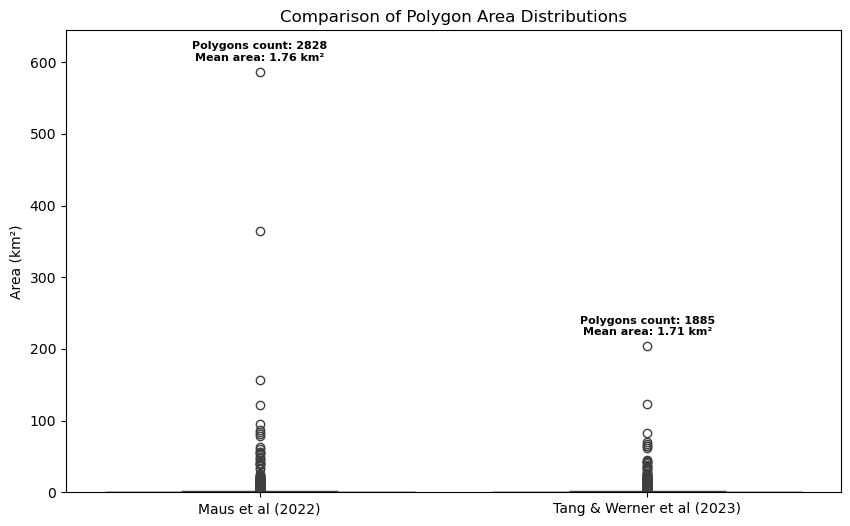

,Dataset,Polygon Count,Min Area (km²),Mean Area (km²),Median Area (km²),Max Area (km²)
0,Maus et al (2022),2828,0.000353,1.756474,0.150263,585.820363
1,Tang & Werner et al (2023),1885,0.001375,1.709219,0.212094,203.353532


In [127]:
polygons_areas = analyze_and_compare_polygon_areas(maus_canada_gdf, 
                                  tang_canada_gdf,
                                  'Maus et al (2022)', 
                                  'Tang & Werner et al (2023)',
                                  save_path=r'results/maus_tang_comparison_polygons.png'
                                  )
polygons_areas


### Create indigenous table

In [139]:
indigenous_gdf = gpd.read_file(r'data/Sources/Indigenous_lands/Indigenous_comm_lands_v202411/Indigenous_comm_lands_v202411/CommunityLevelData_poly_202411.shp')
indigenous_can_gdf = indigenous_gdf[indigenous_gdf['Country'] == 'Canada']

In [140]:
indigenous_can_gdf

,Name,Identity,Form_Rec,Doc_Status,Stat_Date,Stat_Note,Country,ISO_Code,Category,Ethncty_1,...,Data_Ctrb,Data_Src,Data_Src_S,Data_Src_L,Data_Date,Add_Note,More_info,Layer,Download,geometry
2864,Nicola Lake 1,Indigenous,Acknowledged by govt,Documented,None,None,Canada,CAN,Indian Reserve,None,...,Publicly available,"Natural Resources Canada, Earth Sciences Secto...",Natural Resources Canada,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,None,http://clss.nrcan.gc.ca/map-carte-eng.php?can=...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-13411703.632 6478826.437 0....
2865,Piikani Reserve,Indigenous,Acknowledged by govt,Documented,None,None,Canada,CAN,Indian Reserve,None,...,Publicly available,"Natural Resources Canada, Earth Sciences Secto...",Natural Resources Canada,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,None,http://clss.nrcan.gc.ca/map-carte-eng.php?can=...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-12662303.780 6356833.571 0....
2866,Suwannee Lake Indian Reserve 09924,Indigenous,Acknowledged by govt,Documented,None,None,Canada,CAN,Indian Reserve,None,...,Publicly available,"Natural Resources Canada, Earth Sciences Secto...",Natural Resources Canada,"Natural Resources Canada, Earth Sciences Secto...",2013/05/30,None,http://clss.nrcan.gc.ca/map-carte-eng.php?can=...,Indigenous & Community La,Yes,"POLYGON Z ((-11149110.724 7581557.313 0.000, -..."
2867,Chitek Lake I.r. 191,Indigenous,Acknowledged by govt,Documented,None,None,Canada,CAN,Indian Reserve,None,...,Publicly available,"Natural Resources Canada, Earth Sciences Secto...",Natural Resources Canada,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,None,http://clss.nrcan.gc.ca/map-carte-eng.php?can=...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-11998607.890 7110898.048 0....
2868,Couchiching Indian Reserve No. 16a,Indigenous,Acknowledged by govt,Documented,None,None,Canada,CAN,Indian Reserve,None,...,Publicly available,"Natural Resources Canada, Earth Sciences Secto...",Natural Resources Canada,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,None,http://clss.nrcan.gc.ca/map-carte-eng.php?can=...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-10393249.315 6212569.016 0....
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53214,Maa-nulth,Indigenous,Acknowledged by govt,Documented,2011/04/01,None,Canada,CAN,First Nations Treaty Lands,Ucluelet First Nation,...,Publicly Available,Ministry of Aboriginal Relations and Reconcili...,Ministry of Aboriginal Relations and Reconcili...,"Government of British Columbia, Ministry of Ab...",2016/06/09,None,https://catalogue.data.gov.bc.ca/dataset/first...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-13935183.390 6271232.271 0....
53215,Maa-nulth,Indigenous,Acknowledged by govt,Documented,2011/04/01,None,Canada,CAN,First Nations Treaty Lands,Ucluelet First Nation,...,Publicly Available,Ministry of Aboriginal Relations and Reconcili...,Ministry of Aboriginal Relations and Reconcili...,"Government of British Columbia, Ministry of Ab...",2016/06/09,None,https://catalogue.data.gov.bc.ca/dataset/first...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-13915849.512 6301673.475 0....
53216,Maa-nulth,Indigenous,Acknowledged by govt,Documented,2011/04/01,None,Canada,CAN,First Nations Treaty Lands,Ucluelet First Nation,...,Publicly Available,Ministry of Aboriginal Relations and Reconcili...,Ministry of Aboriginal Relations and Reconcili...,"Government of British Columbia, Ministry of Ab...",2016/06/09,None,https://catalogue.data.gov.bc.ca/dataset/first...,Indigenous & Community La,Yes,MULTIPOLYGON Z (((-13912007.673 6290368.700 0....
53217,Maa-nulth,Indigenous,Acknowledged by govt,Documented,2011/04/01,None,Canada,CAN,First Nations Treaty Lands,Ucluelet First Nation,...,Publicly Available,Ministry of Aboriginal Relations and Reconcili...,Ministry of Aboriginal Relations and Reconcili...,"Government of British Columbia, Minist

In [129]:
col_to_keep = ['Name', 'Category', 'Data_Src', 'Data_Date', 'geometry']
indigenous_can_gdf = indigenous_can_gdf[col_to_keep] 

In [130]:
# Simplify geometries while keeping essential shape 
tolerance = 100  # 100 meters simplification tolerance
indigenous_can_gdf["geometry"] = indigenous_can_gdf["geometry"].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True))
# Fix invalid geometries after simplification
indigenous_can_gdf["geometry"] = indigenous_can_gdf["geometry"].buffer(0)

In [131]:
indigenous_can_gdf = assign_id(
    indigenous_can_gdf,
    canada_provinces,
    id_column = "indigenous_land_id",
    prefix='IND',
    name_col='Name'
)

In [132]:
indigenous_can_gdf

,indigenous_land_id,Name,Category,Data_Src,Data_Date,geometry,longitude,latitude
2864,ZZ-IND-65515118,Nicola Lake 1,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,MULTIPOLYGON Z (((-13412001.078 6484020.720 0....,-1.340968e+07,6.482531e+06
2865,ZZ-IND-822586b0,Piikani Reserve,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2012/09/05,MULTIPOLYGON Z (((-12638644.679 6375535.364 0....,-1.265128e+07,6.375071e+06
2866,ZZ-IND-cf5cc3a8,Suwannee Lake Indian Reserve 09924,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/05/30,"POLYGON Z ((-11149110.724 7581557.313 0.000, -...",-1.114723e+07,7.586468e+06
2867,ZZ-IND-d4241875,Chitek Lake I.r. 191,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,MULTIPOLYGON Z (((-11991380.215 7116416.576 0....,-1.199724e+07,7.113774e+06
2868,ZZ-IND-ee5d19c4,Couchiching Indian Reserve No. 16a,Indian Reserve,"Natural Resources Canada, Earth Sciences Secto...",2013/09/09,MULTIPOLYGON Z (((-10398281.993 6223676.777 0....,-1.040011e+07,6.221741e+06
...,...,...,...,...,...,...,...,...
53214,ZZ-IND-ace3fb37,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13935109.163 6271300.023 0....,-1.393595e+07,6.271393e+06
53215,ZZ-IND-07b0f9d4,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13915849.512 6301673.475 0....,-1.391666e+07,6.302849e+06
53216,ZZ-IND-2cec7703,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13900991.756 6286092.967 0....,-1.390820e+07,6.289657e+06
53217,ZZ-IND-a914af3f,Maa-nulth,First Nations Treaty Lands,Ministry of Aboriginal Relations and Reconcili...,2016/06/09,MULTIPOLYGON Z (((-13981167.298 6267857.450 0....,-1.398181e+07,6.269168e+06


### Create protected areas table

In [152]:
# Polygons
wpda_gdf_polygons_1 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_0\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')
wpda_gdf_polygons_2 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_1\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')
wpda_gdf_polygons_3 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_2\WDPA_WDOECM_Mar2025_Public_CAN_shp-polygons.shp')

# Points
wpda_gdf_points_1 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_0\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')
wpda_gdf_points_2 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_1\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')
wpda_gdf_points_3 = gpd.read_file(r'data\Sources\Protected_areas\WDPA_WDOECM_Mar2025_Public_CAN_shp\WDPA_WDOECM_Mar2025_Public_CAN_shp_2\WDPA_WDOECM_Mar2025_Public_CAN_shp-points.shp')

In [153]:
# We merge the 3 files together
wpda_gdf_polygons = gpd.GeoDataFrame(pd.concat([
    wpda_gdf_polygons_1, wpda_gdf_polygons_2, wpda_gdf_polygons_3], 
    ignore_index=True))

wpda_gdf_points = gpd.GeoDataFrame(pd.concat([
    wpda_gdf_points_1, wpda_gdf_points_2, wpda_gdf_points_3], 
    ignore_index=True))

In [154]:
# Convert MULTIPOINT geometries to POINT
def multipoint_to_point(geom):
    """Extracts the first point from a MULTIPOINT."""
    if geom.geom_type == "MultiPoint":
        return geom.geoms[0]  # Extract first point
    return geom  # Return as-is if it's already a Point

In [155]:
wpda_gdf_points["geometry"] = wpda_gdf_points["geometry"].apply(multipoint_to_point)

In [156]:
wpda_gdf_polygons

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,611.0,611_A,1,Wood Buffalo National Park Of Canada,Wood Buffalo National Park Of Canada,National Park,National Park,National,II,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-AB,CAN,CAN,Not Applicable,Not Applicable,"POLYGON ((-112.87253 59.99877, -112.86600 59.9..."
1,611.0,611_B,1,Wood Buffalo National Park Of Canada,Wood Buffalo National Park Of Canada,National Park,National Park,National,II,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-NT,CAN,CAN,Not Applicable,Not Applicable,"POLYGON ((-112.87253 59.99877, -115.57021 59.9..."
2,612.0,612,1,Kluane National Park Reserve Of Canada,Kluane National Park Reserve Of Canada,National Park,National Park,National,II,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-YT,CAN,CAN,Not Applicable,Not Applicable,"POLYGON ((-139.22933 61.23289, -139.22871 61.2..."
3,613.0,613_B,1,Auyuittuq National Park Of Canada,Auyuittuq National Park Of Canada,National Park,National Park,National,II,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-NU,CAN,CAN,Not Applicable,Not Applicable,"MULTIPOLYGON (((-64.02380 67.31413, -63.95370 ..."
4,613.0,613_A,1,Auyuittuq National Park Of Canada,Auyuittuq National Park Of Canada,National Park,National Park,National,II,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-NU,CAN,CAN,Not Applicable,Not Applicable,"MULTIPOLYGON (((-67.01225 68.28855, -67.00854 ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13463,555785733.0,555785733,0,Grosse Île and the Irish Memorial National His...,Lieu historique national de la Grosse-Île-et-l...,Lieu historique national,National Historic Site,National,Not Applicable,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-QC,CAN,CAN,Not Reported,Ancillary,"MULTIPOLYGON (((-70.67700 47.02266, -70.67721 ..."
13464,555785734.0,555785734,0,Navy Island National Historic Site,Navy Island National Historic Site,National Historic Site,National Historic Site,National,Not Applicable,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-ON,CAN,CAN,Not Reported,Ancillary,"POLYGON ((-79.02213 43.06083, -79.02228 43.061..."
13465,555785735.0,555785735,0,Fort George National Historic Site (Paradise G...,Fort George National Historic Site (Paradise G...,National Historic Site,National Historic Site,National,Not Applicable,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-ON,CAN,CAN,Not Reported,Ancillary,"POLYGON ((-79.06321 43.24562, -79.06291 43.245..."
13466,555785736.0,555785736,0,Rideau Canal National Historic Site,Rideau Canal National Historic Site,National Historic Site,National Historic Site,National,Not Applicable,Not Applicable,...,Parks Canada Agency,http://www.pc.gc.ca/,State Verified,1868,CA-ON,CAN,CAN,Not Reported,Ancillary,"MULTIPOLYGON (((-76.23992 44.89998, -76.23966 ..."


In [157]:
wpda_gdf_points

,WDPAID,WDPA_PID,PA_DEF,NAME,ORIG_NAME,DESIG,DESIG_ENG,DESIG_TYPE,IUCN_CAT,INT_CRIT,...,MANG_AUTH,MANG_PLAN,VERIF,METADATAID,SUB_LOC,PARENT_ISO,ISO3,SUPP_INFO,CONS_OBJ,geometry
0,67855.0,67855,1,Tabusintac Lagoon and River Estuary,Tabusintac Lagoon and River Estuary,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(i)(iv),...,Not Reported,Management plan is not implemented and not ava...,State Verified,1856,CA-NB,CAN,CAN,Not Applicable,Not Applicable,POINT (-64.93333 47.33333)
1,166868.0,166868,1,Minesing Swamp,Minesing Swamp,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(i)(ii)(iii),...,Not Reported,Management plan is implemented and is available,State Verified,1856,CA-ON,CAN,CAN,Not Applicable,Not Applicable,POINT (-80.86667 44.38333)
2,166867.0,166867,1,Matchedash Bay,Matchedash Bay,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(i)(ii)(iii)(iv)(viii),...,Not Reported,Management plan is implemented and is available,State Verified,1856,CA-ON,CAN,CAN,Not Applicable,Not Applicable,POINT (-79.66667 44.73333)
3,166866.0,166866,1,Lac Saint Pierre,Lac Saint Pierre,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(i)(ii)(iii)(iv)(v)(vi),...,Not Reported,Management plan is not implemented and not ava...,State Verified,1856,CA-QC,CAN,CAN,Not Applicable,Not Applicable,POINT (-72.65000 46.13333)
4,902694.0,902694,1,Columbia Wetlands,Columbia Wetlands,"Ramsar Site, Wetland of International Importance","Ramsar Site, Wetland of International Importance",International,Not Reported,(i)(ii)(iii)(iv)(v)(vi)(vii)(viii),...,Not Reported,Management plan is implemented and is available,State Verified,1856,CA-BC,CAN,CAN,Not Applicable,Not Applicable,POINT (-115.21667 50.68333)
5,2058.0,2058,1,Mont Saint Hilaire,Mont Saint Hilaire,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,State Verified,988,CA-ON,CAN,CAN,Not Applicable,Not Applicable,POINT (-75.16667 45.55000)
6,11586.0,11586,1,Riding Mountain Biosphere Reserve,Riding Mountain Biosphere Reserve,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,State Verified,988,CA-MB,CAN,CAN,Not Applicable,Not Applicable,POINT (-100.30000 50.76670)
7,11587.0,11587,1,Long Point Biosphere Reserve,Long Point Biosphere Reserve,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,State Verified,988,CA-ON,CAN,CAN,Not Applicable,Not Applicable,POINT (-80.33000 43.58000)
8,18922.0,18922,1,Réserve de la biosphère de Charlevoix,Réserve de la biosphère de Charlevoix,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,State Verified,988,CA-QC,CAN,CAN,Not Applicable,Not Applicable,POINT (-70.55000 47.66667)
9,20014.0,20014,1,Niagara Escarpment Biosphere Reserve,Niagara Escarpment Biosphere Reserve,UNESCO-MAB Biosphere Reserve,UNESCO-MAB Biosphere Reserve,International,Not Applicable,Not Applicable,...,Not Reported,Not Reported,State Verified,988,CA-ON,CAN,CAN,Not Applicable,Not Applicable,POINT (-79.93000 43.62000)


In [158]:
col_to_keep = ['WDPA_PID', 'NAME', 'DESIG', 'OWN_TYPE', 'MANG_AUTH', 'STATUS_YR', 'geometry']
wpda_gdf_polygons = wpda_gdf_polygons[col_to_keep]
wpda_gdf_points = wpda_gdf_points[col_to_keep]

In [159]:
# Simplify geometries while keeping essential shape 
tolerance = 100  # 100 meters simplification tolerance
wpda_gdf_polygons["geometry"] = wpda_gdf_polygons["geometry"].apply(lambda geom: geom.simplify(tolerance, preserve_topology=True))
# Fix invalid geometries after simplification
wpda_gdf_polygons["geometry"] = wpda_gdf_polygons["geometry"].buffer(0)

C:\Users\mp_ma\anaconda3\envs\gis\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [160]:
wpda_gdf_polygons

,WDPA_PID,NAME,DESIG,OWN_TYPE,MANG_AUTH,STATUS_YR,geometry
0,611_A,Wood Buffalo National Park Of Canada,National Park,State,Parks Canada Agency,1922,"POLYGON ((-112.87253 59.99877, -111.53006 59.7..."
1,611_B,Wood Buffalo National Park Of Canada,National Park,State,Parks Canada Agency,1922,"POLYGON ((-112.87253 59.99877, -115.58450 59.9..."
2,612,Kluane National Park Reserve Of Canada,National Park,State,Parks Canada Agency,1972,"POLYGON ((-141.00187 60.30634, -137.43466 60.7..."
3,613_B,Auyuittuq National Park Of Canada,National Park,State,Parks Canada Agency,1972,"MULTIPOLYGON (((-64.62292 67.13706, -63.92605 ..."
4,613_A,Auyuittuq National Park Of Canada,National Park,State,Parks Canada Agency,1972,"MULTIPOLYGON (((-68.23194 67.76712, -67.56846 ..."
...,...,...,...,...,...,...,...
13463,555785733,Grosse Île and the Irish Memorial National His...,Lieu historique national,State,Parks Canada Agency,2023,"MULTIPOLYGON (((-70.67843 47.01639, -70.67802 ..."
13464,555785734,Navy Island National Historic Site,National Historic Site,State,Parks Canada Agency,2023,"POLYGON ((-79.01037 43.04900, -79.00871 43.060..."
13465,555785735,Fort George National Historic Site (Paradise G...,National Historic Site,State,Parks Canada Agency,2023,"POLYGON ((-79.06782 43.24368, -79.05901 43.248..."
13466,555785736,Rideau Canal National Historic Site,National Historic Site,State,Parks Canada Agency,2023,"MULTIPOLYGON (((-76.24341 44.90190, -76.19385 ..."


In [161]:
wpda_gdf_points

,WDPA_PID,NAME,DESIG,OWN_TYPE,MANG_AUTH,STATUS_YR,geometry
0,67855,Tabusintac Lagoon and River Estuary,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1993,POINT (-64.93333 47.33333)
1,166868,Minesing Swamp,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1996,POINT (-80.86667 44.38333)
2,166867,Matchedash Bay,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1996,POINT (-79.66667 44.73333)
3,166866,Lac Saint Pierre,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,1998,POINT (-72.65000 46.13333)
4,902694,Columbia Wetlands,"Ramsar Site, Wetland of International Importance",Not Reported,Not Reported,2005,POINT (-115.21667 50.68333)
5,2058,Mont Saint Hilaire,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1978,POINT (-75.16667 45.55000)
6,11586,Riding Mountain Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1986,POINT (-100.30000 50.76670)
7,11587,Long Point Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1986,POINT (-80.33000 43.58000)
8,18922,Réserve de la biosphère de Charlevoix,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1988,POINT (-70.55000 47.66667)
9,20014,Niagara Escarpment Biosphere Reserve,UNESCO-MAB Biosphere Reserve,Not Reported,Not Reported,1990,POINT (-79.93000 43.62000)


# Saving GeoDataFrames to GeoJSON

In [76]:
# Issue when saving to GeoJSON
ghg_gdf["year"] = ghg_gdf["year"].astype(int)
ghg_gdf["ghg_id"] = ghg_gdf["ghg_id"].astype(int)

pollutant_gdf["year"] = pollutant_gdf["year"].astype(int)
pollutant_gdf["npri_id"] = pollutant_gdf["npri_id"].astype(int)

In [77]:
#main_gdf.to_file(r'data/Tables/GeoJSON/main_gdf.geojson', driver="GeoJSON")
#tailings_gdf.to_file(r'data/Tables/GeoJSON/tailings_gdf.geojson', driver="GeoJSON")
#min_can_gdf.to_file(r'data/Tables/GeoJSON/min_can_gdf.geojson', driver="GeoJSON")
#conflict_gdf.to_file(r'data/Tables/GeoJSON/conflict_gdf.geojson', driver="GeoJSON")
#ghg_gdf.to_file(r'data/Tables/GeoJSON/ghg_gdf.geojson', driver="GeoJSON")
#pollutant_gdf.to_file(r'data/Tables/GeoJSON/pollutant_gdf.geojson', driver="GeoJSON")
# climate_category_gdf.to_file(r'data/Tables/GeoJSON/climate_category_gdf.geojson', driver="GeoJSON")
# weather_gdf.to_file(r'data/Tables/GeoJSON/weather_gdf.geojson', driver="GeoJSON")
# peatland_gdf.to_file(r'data/Tables/GeoJSON/peatland_gdf.geojson', driver="GeoJSON")
# population_gdf.to_file(r'data/Tables/GeoJSON/population_gdf.geojson', driver="GeoJSON")
# water_risk_gdf.to_file(r'data/Tables/GeoJSON/water_risk_gdf.geojson', driver="GeoJSON")
# land_cover_gdf.to_file(r'data/Tables/GeoJSON/land_cover_gdf.geojson', driver="GeoJSON")
# npv_gdf.to_file(r'data/Tables/GeoJSON/npv_gdf.geojson', driver="GeoJSON")
# indigenous_can_gdf.to_file(r'data/Tables/GeoJSON/indigenous_can_gdf.geojson', driver="GeoJSON")
#wpda_gdf_polygons.to_file(r'data/Tables/GeoJSON/wpda_gdf_polygons.geojson', driver="GeoJSON")
#wpda_gdf_points.to_file(r'data/Tables/GeoJSON/wpda_gdf_points.geojson', driver="GeoJSON")
#tang_canada_gdf.to_file(r'data/Tables/GeoJSON/tang_canada_gdf.geojson', driver="GeoJSON")
# maus_canada_gdf.to_file(r'data/Tables/GeoJSON/maus_canada_gdf.geojson', driver="GeoJSON")